In [1]:
## import libraries
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import normaltest, levene, mannwhitneyu, chi2_contingency
from statsmodels.stats import proportion
from math import sqrt
from sklearn.linear_model import LinearRegression

# ignore warnings (not good practise, but there are a lot of spammy deprecated warnings and other things 
# that are not applicable and clutter the output)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# make folder if it does not exist yet
if not os.path.exists('figures'):
    os.mkdir('figures')

In [3]:
## recurring variables

# waves of the study
waves = list(range(1, 8))

# pre-defined drinker types
# A = abstainer, M = moderate drinker, H = heavy drinker
drinker_types = ['A', 'M', 'H']

# limits of these types
drinker_type_bins = (-np.inf, 0, 14, np.inf) 

# modifyer to limits if participant is female
female_modifier = .5 # NOTE: assuming sex-dependent tolerance is linear

# order and color in which I want drinker types to appear in plots and tables
order = {'A' : 0, 'M' : 1, 'H' : 2}
colors = {'A' : 'green', 'M' : 'yellow', 'H' : 'red'}
color_mods = {'A' : .2, 'M' : .6, 'H' : 1} # transparency to distinguish previous type

In [4]:
# helper function to drop columns only when they are present
def drop_columns(data, columns):
    columns = [column for column in columns if column in data.columns]
    return data.drop(columns = columns)

In [5]:
# import data
raw_data = pd.concat(pd.read_pickle('data.pkl'), ignore_index = True)

# impose drinking age limit
raw_data = raw_data[raw_data['age'] >= 21]

In [6]:
## define edge_data rows as relations
edge_data = raw_data[['shareid', 'sharealterid', 'wave']].rename(columns = {'shareid' : 'id_ego',  
                                                                            'sharealterid' : 'id_alter'})

edge_data

,id_ego,id_alter,wave
0,18916,19234,1
1,3687,19234,1
2,18916,9338,1
3,3687,9338,1
4,18916,3687,1
...,...,...,...
254324,18841,8744,7
254325,18841,19252,7
254329,12398,23989,7
254330,12398,7166,7


In [7]:
## define data rows as participant observations

# draw from both egos and alters data to fill in if either is missing
egos = raw_data[['shareid', 'dpw', 'd_state_ego', 'wave', 'sex_ego', 'age']].rename(columns = {'shareid' : 'id',  
                                                                             'd_state_ego' : 'drinker_type',
                                                                             'dpw' : 'drinks_per_week',
                                                                             'sex_ego' : 'sex'})
alters = raw_data[['sharealterid', 'dpw_alter', 'd_state_alter', 'wave', 'sex_alter', 'alter_age']].rename(columns = {'sharealterid' : 'id', 
                                                                                             'dpw_alter' : 'drinks_per_week', 
                                                                                             'd_state_alter' : 'drinker_type',
                                                                                             'sex_alter' : 'sex',
                                                                                             'alter_age' : 'age'})

# merge, drop nan so that duplicates with 1 nan don't accidentally drop the non-nan, 
# then drop non-nan duplicates and format
data = pd.concat([egos, alters]).dropna(subset = ['drinker_type'], axis = 0).drop_duplicates().reset_index(drop = True)

# drop drinker_type -1 for people that are either M or H depending on missing gender
data = data.drop(data[~data['drinker_type'].isin([0, 1, 2])].index)

# format
data['drinker_type'] = data['drinker_type'].map({0 : 'A', 
                                                 1 : 'M',
                                                 2 : 'H'})
data['drinks_per_week'] = data['drinks_per_week'].astype('int32')
data['sex'] = data['sex'].map({1 : 'male',
                               2 : 'female'})

data

,id,drinks_per_week,drinker_type,wave,sex,age
0,18916,1,M,1,female,30.0
1,3687,26,H,1,male,28.0
2,11189,21,H,1,male,22.0
3,17046,14,M,1,male,23.0
4,18969,7,M,1,male,24.0
...,...,...,...,...,...,...
34195,23382,0,A,6,NaN,57.0
34196,3047,0,A,6,female,82.0
34197,6844,0,A,7,NaN,68.0
34198,23530,6,M,7,male,50.0


In [8]:
# investigate cause of quitting the study
raw_data['CAUSESEVERED'].value_counts()

CAUSESEVERED
CENSORED             75124
EGO DEATH            30999
ALTER DEATH          30503
NOT NAMED            12054
reciprocal_friend     4366
EGO ATTRIT              36
ALTER ATTR              30
BOTH DEATH               2
Name: count, dtype: int64

In [9]:
## makes drinker type definitions costumizable by re-inferring limits from sex and drinks per week

# for comparing to given drinker type
test = data['drinker_type']

# determine drinker type based on drinks per week and sex
data['drinker_type'] = data['drinks_per_week']
data['sex_mod'] = data['sex'].replace({'male' : 1, 'female' : 1 / female_modifier})
data['drinker_type'] = data['drinker_type'] * data['sex_mod']
data = data.assign(drinker_type = pd.cut(data['drinker_type'], 
                                  bins = drinker_type_bins, 
                                  labels = ['A', 'M', 'H']).astype(str).replace('nan', np.nan))

# fill  drinker type when it is the same regardless of sex
def fill_type(bins, label):
    data['drinker_type'] = data['drinker_type'].fillna(pd.cut(data['drinks_per_week'], 
                                                              bins = bins, 
                                                              labels = [label]
                                                             ).astype(str).replace('nan', np.nan))

fill_type(np.array(drinker_type_bins[:2]) * female_modifier, 'A')
fill_type([drinker_type_bins[1], drinker_type_bins[2] * female_modifier], 'M')
fill_type(drinker_type_bins[2:], 'H')

print('show the different in predetermined drinker type and my generated version:')
display(data['drinker_type'].compare(test))

# remove nans and temporary series
data = data.dropna(subset = ['drinker_type'], axis = 0)
data = drop_columns(data, ['sex_mod', 'sex'])

data

show the different in predetermined drinker type and my generated version:


,self,other


,id,drinks_per_week,drinker_type,wave,age
0,18916,1,M,1,30.0
1,3687,26,H,1,28.0
2,11189,21,H,1,22.0
3,17046,14,M,1,23.0
4,18969,7,M,1,24.0
...,...,...,...,...,...
34195,23382,0,A,6,57.0
34196,3047,0,A,6,82.0
34197,6844,0,A,7,68.0
34198,23530,6,M,7,50.0


In [10]:
## look at transition per year instead of per wave with linear interpolation
# NOTE: this can be done way more efficiently, but I am not using it, so leaving it like this for now
def per_year(data, wave_intervals = [7, 3, 3, 3, 3, 4]):
    curs = None
    new_data = pd.DataFrame()
    year = 0
    for next_wave in range(1, 8):
        nexts = data[data['wave'] == next_wave]
        
        if curs is not None:
            interpolate_ids = curs[curs['id'].isin(nexts['id'])]['id'].tolist()
            interval = wave_intervals[next_wave - 2]
            curs['year'] = year
            new_data = pd.concat([new_data, curs])
            
            for interpolater in range(1, interval):
                year += 1
                dpw_diff = {interpolate_id : nexts[nexts['id'] == interpolate_id]['drinks_per_week'].iloc[0] - curs[curs['id'] == interpolate_id]['drinks_per_week'].iloc[0] for interpolate_id in interpolate_ids}
                
                new_year = curs[curs['id'].isin(interpolate_ids)]
                new_year['year'] = year
                new_year['drinks_per_week'] += new_year.apply(lambda row : (dpw_diff[row['id']] / interval) * interpolater, axis = 1)
                new_year['drinker_type'] = new_year.apply(drinker_type, axis = 1)
                
                new_data = pd.concat([new_data, new_year])
            
            year += 1
        
        curs = nexts
        
    nexts['year'] = year
    return pd.concat([new_data, nexts])

# comment next line to apply yearly interpolation
'''
data = per_year(data) 
data
#'''

'\ndata = per_year(data) \ndata\n#'

In [11]:
## define prev_drinker_type column that is the previously observed drinker type until a defined lookback limit

# determines how many waves to look back for previous observation
lookback = waves[:-1] # looks back all waves

# initialize column for previous drinker type
data['drinker_type_prev'] = np.nan

for wave_shift in lookback:
    # determine drinker type of earlier wave
    prev_type = data[['id', 'wave', 'drinker_type']].rename(columns = {'drinker_type' : f'drinker_type_-{wave_shift}'})
    prev_type['wave'] += wave_shift
    data = prev_type.merge(data, on = ['id', 'wave'], how = 'right')
    
    # fill unknown values with found data
    data['drinker_type_prev'] = data['drinker_type_prev'].fillna(data[f'drinker_type_-{wave_shift}'])
    
data

,id,wave,drinker_type_-6,drinker_type_-5,drinker_type_-4,drinker_type_-3,drinker_type_-2,drinker_type_-1,drinks_per_week,drinker_type,age,drinker_type_prev
0,18916,1,NaN,NaN,NaN,NaN,NaN,NaN,1,M,30.0,NaN
1,3687,1,NaN,NaN,NaN,NaN,NaN,NaN,26,H,28.0,NaN
2,11189,1,NaN,NaN,NaN,NaN,NaN,NaN,21,H,22.0,NaN
3,17046,1,NaN,NaN,NaN,NaN,NaN,NaN,14,M,23.0,NaN
4,18969,1,NaN,NaN,NaN,NaN,NaN,NaN,7,M,24.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
33896,23382,6,NaN,M,M,M,M,NaN,0,A,57.0,M
33897,3047,6,NaN,M,A,A,A,A,0,A,82.0,A
33898,6844,7,M,NaN,NaN,NaN,NaN,NaN,0,A,68.0,M
33899,23530,7,M,M,NaN,NaN,NaN,M,6,M,50.0,M


In [12]:
## create has_been column which states which drinker type the person has been (including currently)

# list drinker types of current and all prior waves
data['has_been_all'] = data['drinker_type']
for wave_shift in lookback:
    data['has_been_all'] += data[f'drinker_type_-{wave_shift}'].fillna('')

# determine which drinker types occur in list
for drinker_type in drinker_types:
    data[f'has_been_{drinker_type}'] = data['has_been_all'].str.count(drinker_type) != 0

# format
data['has_been'] = ''
data['has_been'].loc[data['has_been_A']] += 'A'
data['has_been'].loc[data['has_been_M']] += 'M'
data['has_been'].loc[data['has_been_H']] += 'H'

# drop temporary series
wave_shift_columns = [f'drinker_type_-{waveshift}' for waveshift in lookback]
has_been_columns = [f'has_been_{drinker_type}' for drinker_type in drinker_types + ['all']]
data = drop_columns(data, wave_shift_columns + has_been_columns)

data

,id,wave,drinks_per_week,drinker_type,age,drinker_type_prev,has_been
0,18916,1,1,M,30.0,NaN,M
1,3687,1,26,H,28.0,NaN,H
2,11189,1,21,H,22.0,NaN,H
3,17046,1,14,M,23.0,NaN,M
4,18969,1,7,M,24.0,NaN,M
...,...,...,...,...,...,...,...
33896,23382,6,0,A,57.0,M,AM
33897,3047,6,0,A,82.0,A,AM
33898,6844,7,0,A,68.0,M,AM
33899,23530,7,6,M,50.0,M,M


In [13]:
## define lapse column that states whether an observation is a sudden H after an A
data['lapse'] = (data['drinker_type'] == 'H') & (data['drinker_type_prev'] == 'A')

display(data)

,id,wave,drinks_per_week,drinker_type,age,drinker_type_prev,has_been,lapse
0,18916,1,1,M,30.0,NaN,M,False
1,3687,1,26,H,28.0,NaN,H,False
2,11189,1,21,H,22.0,NaN,H,False
3,17046,1,14,M,23.0,NaN,M,False
4,18969,1,7,M,24.0,NaN,M,False
...,...,...,...,...,...,...,...,...
33896,23382,6,0,A,57.0,M,AM,False
33897,3047,6,0,A,82.0,A,AM,False
33898,6844,7,0,A,68.0,M,AM,False
33899,23530,7,6,M,50.0,M,M,False


In [14]:
## create recovered columns for whether participant used to be H but is now A
data['recovered'] = (data['drinker_type'] == 'A') & data['has_been'].apply(lambda has_been: 'H' in has_been)

data

,id,wave,drinks_per_week,drinker_type,age,drinker_type_prev,has_been,lapse,recovered
0,18916,1,1,M,30.0,NaN,M,False,False
1,3687,1,26,H,28.0,NaN,H,False,False
2,11189,1,21,H,22.0,NaN,H,False,False
3,17046,1,14,M,23.0,NaN,M,False,False
4,18969,1,7,M,24.0,NaN,M,False,False
...,...,...,...,...,...,...,...,...,...
33896,23382,6,0,A,57.0,M,AM,False,False
33897,3047,6,0,A,82.0,A,AM,False,False
33898,6844,7,0,A,68.0,M,AM,False,False
33899,23530,7,6,M,50.0,M,M,False,False


In [15]:
## create new column for social links of each participant in that wave

# drop links if already made to prevent breaking the code
data = drop_columns(data, ['links'])

# expand each link for every observation
data_per_link = data.merge(edge_data.rename(columns = {'id_ego' : 'id'}), 
                           on = ['id', 'wave'],
                           how = 'left').dropna(subset = ['id_alter'])

# format
data_per_link = data_per_link.rename(columns = {'id_alter' : 'links'})
data_per_link['links'] = data_per_link['links'].astype(int)

# group together to go back to normal data with all links per observation in 1 column
links = data_per_link[['id', 'wave', 'links']].groupby(['wave', 'id'])['links'].apply(list).reset_index()

data = data.merge(links, on = ['wave', 'id'], how = 'left')

# fill nan with empty lists
data['links'] = data['links'].fillna({i: [] for i in data['links'].index})

data

,id,wave,drinks_per_week,drinker_type,age,drinker_type_prev,has_been,lapse,recovered,links
0,18916,1,1,M,30.0,NaN,M,False,False,"[19234, 9338, 3687, 22976]"
1,3687,1,26,H,28.0,NaN,H,False,False,"[19234, 9338, 22976, 9390, 22654, 15008, 25568..."
2,11189,1,21,H,22.0,NaN,H,False,False,"[3687, 9390, 15008, 25568, 1780, 17046, 18969,..."
3,17046,1,14,M,23.0,NaN,M,False,False,"[3687, 9390, 15008, 25568, 1780, 11189, 18969,..."
4,18969,1,7,M,24.0,NaN,M,False,False,"[3687, 9390, 15008, 25568, 1780, 11189, 17046,..."
...,...,...,...,...,...,...,...,...,...,...
33896,23382,6,0,A,57.0,M,AM,False,False,[]
33897,3047,6,0,A,82.0,A,AM,False,False,[]
33898,6844,7,0,A,68.0,M,AM,False,False,[]
33899,23530,7,6,M,50.0,M,M,False,False,[]


In [16]:
## adds columns for states of social network

# remove columns if already added to prevent issues
data  = drop_columns(data, [f'c{drinker_type}' for drinker_type in drinker_types])

# get data of all the links
links = data[['id', 'wave', 'links']].explode('links')
links = links.rename(columns = {'id' : 'source_id',
                                'links' : 'id'})
links = links.merge(data[['id', 'wave', 'drinker_type']], on = ['id', 'wave'], how = 'left')

# group links back per drinker type
links = links[['source_id', 'drinker_type', 'wave']].groupby(['source_id', 'drinker_type', 'wave']).size().reset_index()
links = links.rename(columns = {'source_id' : 'id',
                                0 : 'count'})

# reformat into original data
for drinker_type in drinker_types:
    data = links[links['drinker_type'] == drinker_type][['id', 'wave', 'count']].merge(data, on = ['id', 'wave'], how = 'right')
    data['count'] = data['count'].fillna(0).astype(int)
    data = data.rename(columns = {'count' : f'c{drinker_type}'})

data

,id,wave,cH,cM,cA,drinks_per_week,drinker_type,age,drinker_type_prev,has_been,lapse,recovered,links
0,18916,1,1,1,0,1,M,30.0,NaN,M,False,False,"[19234, 9338, 3687, 22976]"
1,3687,1,2,8,1,26,H,28.0,NaN,H,False,False,"[19234, 9338, 22976, 9390, 22654, 15008, 25568..."
2,11189,1,1,6,1,21,H,22.0,NaN,H,False,False,"[3687, 9390, 15008, 25568, 1780, 17046, 18969,..."
3,17046,1,2,5,1,14,M,23.0,NaN,M,False,False,"[3687, 9390, 15008, 25568, 1780, 11189, 18969,..."
4,18969,1,2,5,1,7,M,24.0,NaN,M,False,False,"[3687, 9390, 15008, 25568, 1780, 11189, 17046,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33896,23382,6,0,0,0,0,A,57.0,M,AM,False,False,[]
33897,3047,6,0,0,0,0,A,82.0,A,AM,False,False,[]
33898,6844,7,0,0,0,0,A,68.0,M,AM,False,False,[]
33899,23530,7,0,0,0,6,M,50.0,M,M,False,False,[]


In [17]:
## add column for whether participant was recovered in the previous wave
def was_recovered(row):
    return len(data[(data['wave'] == row['wave'] - 1) 
                  & (data['id'] == row['id']) 
                  & data['recovered']]) > 0

## create subdataframe of cases that have lapses while previously recovered (relapsers)
relapse_bools = data[data['lapse']].apply(was_recovered, axis = 1)
relapses = data[data['lapse'] & relapse_bools][['id', 'wave']]
relapses.head(5)

,id,wave
13230,11041,3
13642,1378,3
14386,9942,3
16103,8625,3
18312,5869,4


In [18]:
## show all waves of all lapsers to check validity of recovered, lapse, and relapse properties
for lapser in data[data['lapse']]['id']:
    cur_lapser = data[data['id'] == lapser][['wave', 'drinker_type', 'recovered', 'lapse']].sort_values(by = 'wave')
    lapse_type = 're' if len(relapses[relapses['id'] == lapser]) > 0 else 'first-time '
    display(cur_lapser.style.set_caption(f'{lapser}: {lapse_type}lapser'))

,wave,drinker_type,recovered,lapse
33506,1,A,False,False
7319,2,H,False,True
17708,4,A,True,False
22512,5,M,False,False
27262,6,M,False,False
30523,7,A,True,False


,wave,drinker_type,recovered,lapse
204,1,A,False,False
7476,2,H,False,True
12941,3,H,False,False
17876,4,M,False,False
22662,5,M,False,False
26974,6,H,False,False
30234,7,M,False,False


,wave,drinker_type,recovered,lapse
408,1,A,False,False
7651,2,H,False,True
13114,3,M,False,False
18057,4,M,False,False
22819,5,M,False,False
27111,6,M,False,False
30366,7,M,False,False


,wave,drinker_type,recovered,lapse
410,1,A,False,False
7653,2,H,False,True


,wave,drinker_type,recovered,lapse
824,1,A,False,False
8001,2,H,False,True
13428,3,M,False,False
18371,4,H,False,False
23116,5,M,False,False


,wave,drinker_type,recovered,lapse
1084,1,A,False,False
8228,2,H,False,True
13633,3,M,False,False
18586,4,H,False,False
23306,5,H,False,False
27513,6,H,False,False
30773,7,H,False,False


,wave,drinker_type,recovered,lapse
1436,1,A,False,False
8523,2,H,False,True
13912,3,H,False,False
18857,4,H,False,False
23565,5,H,False,False
27704,6,H,False,False
30966,7,A,True,False


,wave,drinker_type,recovered,lapse
1512,1,A,False,False
8588,2,H,False,True
18911,4,A,True,False
31014,7,A,True,False


,wave,drinker_type,recovered,lapse
33534,1,A,False,False
9299,2,H,False,True
14606,3,H,False,False
19548,4,H,False,False
25508,5,A,True,False
32543,7,A,True,False


,wave,drinker_type,recovered,lapse
2503,1,A,False,False
9419,2,H,False,True
14717,3,M,False,False
24303,5,H,False,False


,wave,drinker_type,recovered,lapse
33619,1,A,False,False
9789,2,H,False,True
13380,3,M,False,False
18325,4,M,False,False
23078,5,M,False,False
27318,6,M,False,False
30584,7,M,False,False


,wave,drinker_type,recovered,lapse
3019,1,A,False,False
9856,2,H,False,True
24652,5,A,True,False
28561,6,A,True,False
31863,7,A,True,False


,wave,drinker_type,recovered,lapse
33605,1,A,False,False
9888,2,H,False,True
15150,3,M,False,False
21263,4,A,True,False
25788,5,A,True,False
29429,6,M,False,False
32747,7,M,False,False


,wave,drinker_type,recovered,lapse
33659,1,A,False,False
9965,2,H,False,True
15222,3,M,False,False
20156,4,M,False,False
24755,5,M,False,False
31949,7,M,False,False


,wave,drinker_type,recovered,lapse
3423,1,A,False,False
10171,2,H,False,True
20345,4,A,True,False
24918,5,A,True,False


,wave,drinker_type,recovered,lapse
3530,1,A,False,False
10248,2,H,False,True
20418,4,H,False,False
24991,5,H,False,False


,wave,drinker_type,recovered,lapse
33473,1,A,False,False
10353,2,H,False,True
20516,4,M,False,False
25083,5,M,False,False
29722,6,A,True,False
33054,7,A,True,False


,wave,drinker_type,recovered,lapse
3694,1,A,False,False
10375,2,H,False,True
15602,3,A,True,False
19052,4,A,True,False
23745,5,A,True,False


,wave,drinker_type,recovered,lapse
3898,1,A,False,False
10529,2,H,False,True
15745,3,M,False,False
20675,4,H,False,False
25240,5,M,False,False
29042,6,M,False,False
32347,7,M,False,False


,wave,drinker_type,recovered,lapse
4003,1,A,False,False
10596,2,H,False,True
15821,3,A,True,False
20752,4,A,True,False
22763,5,A,True,False
27058,6,A,True,False
30316,7,A,True,False


,wave,drinker_type,recovered,lapse
4128,1,A,False,False
10685,2,H,False,True
15908,3,M,False,False
20840,4,A,True,False
25390,5,A,True,False
29160,6,M,False,False
30819,7,M,False,False


,wave,drinker_type,recovered,lapse
33448,1,A,False,False
10749,2,H,False,True
18372,4,A,True,False
25447,5,M,False,False
32656,7,A,True,False


,wave,drinker_type,recovered,lapse
6016,1,A,False,False
10939,2,H,False,True


,wave,drinker_type,recovered,lapse
33606,1,A,False,False
11218,2,H,False,True
16375,3,M,False,False
21262,4,H,False,False
25787,5,M,False,False
29428,6,H,False,False
32746,7,H,False,False


,wave,drinker_type,recovered,lapse
5107,1,A,False,False
11398,2,H,False,True
16534,3,H,False,False
21417,4,H,False,False
26119,5,H,False,False
29666,6,M,False,False
32983,7,M,False,False


,wave,drinker_type,recovered,lapse
33582,1,A,False,False
11607,2,H,False,True
16403,3,M,False,False
21603,4,M,False,False
26057,5,M,False,False
29623,6,M,False,False
32940,7,M,False,False


,wave,drinker_type,recovered,lapse
5912,1,A,False,False
11928,2,H,False,True
17003,3,H,False,False
21875,4,M,False,False


,wave,drinker_type,recovered,lapse
33651,1,A,False,False
12009,2,H,False,True
17071,3,M,False,False


,wave,drinker_type,recovered,lapse
33757,1,A,False,False
12083,2,H,False,True
17128,3,M,False,False


,wave,drinker_type,recovered,lapse
6334,1,A,False,False
12229,2,H,False,True
17248,3,A,True,False
22110,4,M,False,False
26528,5,A,True,False
29949,6,A,True,False
33277,7,A,True,False


,wave,drinker_type,recovered,lapse
6494,1,A,False,False
12340,2,H,False,True


,wave,drinker_type,recovered,lapse
6681,1,A,False,False
12458,2,H,False,True


,wave,drinker_type,recovered,lapse
7075,1,A,False,False
12659,2,H,False,True


,wave,drinker_type,recovered,lapse
555,1,H,False,False
7788,2,A,True,False
13230,3,H,False,True
18170,4,H,False,False
22929,5,H,False,False
27195,6,A,True,False
30451,7,A,True,False


,wave,drinker_type,recovered,lapse
1033,1,A,False,False
13591,3,H,False,True
18540,4,H,False,False
23267,5,M,False,False


,wave,drinker_type,recovered,lapse
33533,1,A,False,False
13640,3,H,False,True
18593,4,H,False,False
23313,5,H,False,False
27518,6,H,False,False
30778,7,H,False,False


,wave,drinker_type,recovered,lapse
1093,1,H,False,False
8237,2,A,True,False
13642,3,H,False,True
18595,4,H,False,False
23316,5,H,False,False
27519,6,H,False,False
30779,7,H,False,False


,wave,drinker_type,recovered,lapse
4366,1,H,False,False
10873,2,A,True,False
14386,3,H,False,True


,wave,drinker_type,recovered,lapse
3485,1,M,False,False
10213,2,A,False,False
15442,3,H,False,True
20386,4,H,False,False
24956,5,H,False,False
28811,6,M,False,False
32120,7,H,False,False


,wave,drinker_type,recovered,lapse
2333,1,M,False,False
9264,2,A,False,False
15629,3,H,False,True


,wave,drinker_type,recovered,lapse
3734,1,M,False,False
10406,2,A,False,False
15631,3,H,False,True
20561,4,M,False,False
25200,5,M,False,False
29007,6,H,False,False
32312,7,H,False,False


,wave,drinker_type,recovered,lapse
33733,1,A,False,False
10788,2,A,False,False
15992,3,H,False,True
21725,4,H,False,False
26170,5,M,False,False


,wave,drinker_type,recovered,lapse
4413,1,H,False,False
10904,2,A,True,False
16103,3,H,False,True
21005,4,A,True,False
23439,5,A,True,False


,wave,drinker_type,recovered,lapse
4825,1,M,False,False
11203,2,A,False,False
16167,3,H,False,True
26780,5,H,False,False
33410,7,H,False,False


,wave,drinker_type,recovered,lapse
4583,1,M,False,False
11019,2,A,False,False
16211,3,H,False,True
21094,4,M,False,False


,wave,drinker_type,recovered,lapse
5253,1,M,False,False
11482,2,A,False,False
16623,3,H,False,True
21509,4,M,False,False
25985,5,M,False,False


,wave,drinker_type,recovered,lapse
6131,1,A,False,False
17121,3,H,False,True
21992,4,H,False,False
26414,5,M,False,False
29874,6,M,False,False
33201,7,H,False,False


,wave,drinker_type,recovered,lapse
33710,1,A,False,False
12190,2,A,False,False
17212,3,H,False,True
22081,4,M,False,False
26505,5,M,False,False
29934,6,M,False,False
33263,7,M,False,False


,wave,drinker_type,recovered,lapse
755,1,H,False,False
7941,2,H,False,False
13374,3,A,True,False
18312,4,H,False,True
23071,5,M,False,False
27311,6,M,False,False
30578,7,H,False,False


,wave,drinker_type,recovered,lapse
2902,1,M,False,False
9754,2,M,False,False
15020,3,A,False,False
19946,4,H,False,True
24566,5,H,False,False
28496,6,H,False,False
31794,7,H,False,False


,wave,drinker_type,recovered,lapse
3623,1,H,False,False
10321,2,H,False,False
15543,3,A,True,False
20480,4,H,False,True
25052,5,H,False,False
28889,6,H,False,False
32196,7,H,False,False


,wave,drinker_type,recovered,lapse
3726,1,H,False,False
10399,2,H,False,False
15622,3,A,True,False
20555,4,H,False,True
28942,6,A,True,False
32250,7,A,True,False


,wave,drinker_type,recovered,lapse
4030,1,A,False,False
10616,2,M,False,False
15838,3,A,False,False
20773,4,H,False,True
25330,5,M,False,False
28586,6,H,False,False
31891,7,H,False,False


,wave,drinker_type,recovered,lapse
4524,1,A,False,False
10983,2,M,False,False
16171,3,A,False,False
21065,4,H,False,True
25607,5,A,True,False
29304,6,A,True,False
32616,7,A,True,False


,wave,drinker_type,recovered,lapse
33552,1,A,False,False
21369,4,H,False,True
25875,5,H,False,False
29488,6,H,False,False
32810,7,H,False,False


,wave,drinker_type,recovered,lapse
5218,1,A,False,False
11454,2,A,False,False
16597,3,A,False,False
21479,4,H,False,True


,wave,drinker_type,recovered,lapse
5335,1,A,False,False
21554,4,H,False,True
29598,6,M,False,False
32916,7,A,True,False


,wave,drinker_type,recovered,lapse
6596,1,H,False,False
12406,2,H,False,False
17402,3,A,True,False
22253,4,H,False,True
26663,5,H,False,False
29998,6,H,False,False
33324,7,H,False,False


,wave,drinker_type,recovered,lapse
6782,1,H,False,False
17498,3,A,True,False
22347,4,H,False,True


,wave,drinker_type,recovered,lapse
4332,1,H,False,False
10847,2,A,True,False
12876,3,A,True,False
17807,4,A,True,False
22601,5,H,False,True
26921,6,A,True,False
30183,7,A,True,False


,wave,drinker_type,recovered,lapse
1046,1,M,False,False
8189,2,M,False,False
13601,3,M,False,False
18552,4,A,False,False
23276,5,H,False,True
27488,6,M,False,False
30748,7,M,False,False


,wave,drinker_type,recovered,lapse
1482,1,M,False,False
8568,2,M,False,False
13950,3,M,False,False
18891,4,A,False,False
23599,5,H,False,True
27731,6,M,False,False
30996,7,H,False,False


,wave,drinker_type,recovered,lapse
1940,1,A,False,False
23904,5,H,False,True
27986,6,M,False,False


,wave,drinker_type,recovered,lapse
2672,1,M,False,False
9560,2,M,False,False
14850,3,M,False,False
19780,4,A,False,False
24412,5,H,False,True
28376,6,A,True,False
31661,7,A,True,False


,wave,drinker_type,recovered,lapse
2790,1,H,False,False
9659,2,H,False,False
14939,3,H,False,False
19866,4,A,True,False
24493,5,H,False,True


,wave,drinker_type,recovered,lapse
2916,1,H,False,False
9763,2,H,False,False
15029,3,A,True,False
19955,4,A,True,False
24575,5,H,False,True


,wave,drinker_type,recovered,lapse
3325,1,H,False,False
10092,2,H,False,False
15340,3,H,False,False
20277,4,A,True,False
24854,5,H,False,True


,wave,drinker_type,recovered,lapse
3402,1,M,False,False
10151,2,H,False,False
15391,3,H,False,False
20331,4,A,True,False
24904,5,H,False,True
28764,6,H,False,False
32076,7,H,False,False


,wave,drinker_type,recovered,lapse
3867,1,A,False,False
10502,2,M,False,False
15721,3,M,False,False
20651,4,A,False,False
25215,5,H,False,True
29020,6,M,False,False
32325,7,H,False,False


,wave,drinker_type,recovered,lapse
3947,1,H,False,False
10562,2,M,False,False
15783,3,H,False,False
20714,4,A,True,False
25280,5,H,False,True
29075,6,M,False,False
32377,7,H,False,False


,wave,drinker_type,recovered,lapse
6095,1,M,False,False
12048,2,A,False,False
26394,5,H,False,True


,wave,drinker_type,recovered,lapse
6389,1,A,False,False
12267,2,M,False,False
17274,3,M,False,False
22138,4,A,False,False
26549,5,H,False,True
29961,6,M,False,False


,wave,drinker_type,recovered,lapse
394,1,H,False,False
7637,2,H,False,False
13102,3,M,False,False
18047,4,M,False,False
22812,5,A,True,False
27102,6,H,False,True
30358,7,H,False,False


,wave,drinker_type,recovered,lapse
33504,1,M,False,False
7320,2,H,False,False
12780,3,A,True,False
17709,4,A,True,False
27263,6,H,False,True
30524,7,A,True,False


,wave,drinker_type,recovered,lapse
5070,1,H,False,False
11369,2,M,False,False
24030,5,A,True,False
28084,6,H,False,True
31357,7,H,False,False


,wave,drinker_type,recovered,lapse
3956,1,H,False,False
10567,2,H,False,False
15789,3,A,True,False
25284,5,A,True,False
29078,6,H,False,True
32381,7,H,False,False


,wave,drinker_type,recovered,lapse
4318,1,H,False,False
10831,2,H,False,False
16036,3,M,False,False
17824,4,H,False,False
25500,5,A,True,False
29236,6,H,False,True
32539,7,H,False,False


,wave,drinker_type,recovered,lapse
4710,1,M,False,False
11120,2,H,False,False
13198,3,H,False,False
21172,4,H,False,False
25711,5,H,False,False
27171,6,A,True,False
30424,7,H,False,True


,wave,drinker_type,recovered,lapse
33523,1,M,False,False
13432,3,H,False,False
18376,4,H,False,False
23119,5,M,False,False
27351,6,A,True,False
30618,7,H,False,True


,wave,drinker_type,recovered,lapse
1120,1,M,False,False
8264,2,H,False,False
18619,4,H,False,False
23335,5,H,False,False
27537,6,A,True,False
30797,7,H,False,True


,wave,drinker_type,recovered,lapse
2192,1,A,False,False
9148,2,M,False,False
14472,3,M,False,False
19412,4,M,False,False
24079,5,M,False,False
28123,6,A,False,False
31395,7,H,False,True


,wave,drinker_type,recovered,lapse
2561,1,H,False,False
14766,3,H,False,False
28314,6,A,True,False
31598,7,H,False,True


,wave,drinker_type,recovered,lapse
5795,1,H,False,False
9645,2,H,False,False
14926,3,H,False,False
19855,4,H,False,False
24482,5,H,False,False
28429,6,A,True,False
31722,7,H,False,True


,wave,drinker_type,recovered,lapse
2782,1,H,False,False
9653,2,A,True,False
14931,3,M,False,False
19860,4,A,True,False
24487,5,A,True,False
31727,7,H,False,True


,wave,drinker_type,recovered,lapse
4129,1,H,False,False
10686,2,H,False,False
15073,3,M,False,False
20004,4,M,False,False
24613,5,M,False,False
28532,6,A,True,False
31831,7,H,False,True


,wave,drinker_type,recovered,lapse
3427,1,H,False,False
7325,2,H,False,False
12785,3,H,False,False
20348,4,M,False,False
24921,5,M,False,False
28781,6,A,True,False
32092,7,H,False,True


,wave,drinker_type,recovered,lapse
3915,1,H,False,False
10542,2,M,False,False
15759,3,M,False,False
19922,4,M,False,False
24546,5,H,False,False
29055,6,A,True,False
32357,7,H,False,True


,wave,drinker_type,recovered,lapse
6591,1,M,False,False
22247,4,A,False,False
32410,7,H,False,True


,wave,drinker_type,recovered,lapse
33625,1,H,False,False
10819,2,H,False,False
21874,4,H,False,False
26306,5,A,True,False
29804,6,A,True,False
33135,7,H,False,True


,wave,drinker_type,recovered,lapse
6042,1,M,False,False
12011,2,H,False,False
17073,3,M,False,False
29839,6,A,True,False
33168,7,H,False,True


,wave,drinker_type,recovered,lapse
6281,1,H,False,False
12184,2,H,False,False
17207,3,H,False,False
22076,4,H,False,False
26499,5,H,False,False
29929,6,A,True,False
33259,7,H,False,True


,wave,drinker_type,recovered,lapse
33441,1,A,False,False
33771,2,H,False,True
12902,3,H,False,False
17842,4,A,True,False
22629,5,A,True,False
26946,6,A,True,False
30209,7,A,True,False


,wave,drinker_type,recovered,lapse
33535,1,A,False,False
33783,2,H,False,True
16052,3,A,True,False
20960,4,A,True,False
25507,5,A,True,False
29239,6,A,True,False
32542,7,A,True,False


,wave,drinker_type,recovered,lapse
33594,1,A,False,False
33788,2,H,False,True
22921,5,H,False,False
30443,7,H,False,False


,wave,drinker_type,recovered,lapse
33620,1,A,False,False
33790,2,H,False,True
14825,3,M,False,False
19753,4,A,True,False
24393,5,M,False,False
28356,6,M,False,False


In [19]:
## show demographics of the data

# get useful columns
demographics = data[['wave', 'id', 'age', 'links', 'cA', 'cH', 'drinks_per_week']]

# drop unnessesary columns from data
data = drop_columns(data, ['drinker_per_week'])

# aggregate
demographics['links'] = demographics['links'].apply(len) 
demographics = demographics.groupby('wave').agg({'id' : 'count',
                                                 'age' : 'mean', 
                                                 'drinks_per_week' : 'mean',
                                                 'links' : 'mean', 
                                                 'cA': 'mean', 
                                                 'cH' : 'mean'})
demographics['cA'] /= demographics['links']
demographics['cH'] /= demographics['links']
demographics

,id,age,drinks_per_week,links,cA,cH
wave,,,,,,
1,7647,46.432849,7.279587,4.286518,0.149944,0.171665
2,5507,53.336481,6.999092,4.624841,0.199733,0.135498
3,4954,55.144126,6.323577,4.633428,0.207066,0.109785
4,4836,57.332299,5.273780,4.553350,0.224069,0.088329
5,4362,59.550206,4.976158,4.461715,0.213853,0.079848
6,3262,58.685469,4.985898,4.487124,0.170937,0.061488
7,3333,61.411641,5.422142,4.312931,0.157843,0.070748


In [20]:
## count the number of lapses in the links of a participant

# remove columns if already made to prevent issues
data = drop_columns(data, ['lapses_in_links'])

# get links data
links = data.explode('links')[['id', 'links', 'wave']].dropna()
links = links.rename(columns = {'id' : 'source_id', 
                                'links' : 'id'})

# get whether links has lapsed that wave
links = links.merge(data, on = ['id', 'wave'], how = 'left')[['source_id', 'id', 'wave', 'lapse']].rename(columns = {'lapse' : 'lapses_in_links'})

# filter and format
links = links.dropna()
links = links[links['lapses_in_links']]
links = links[['source_id', 'wave', 'lapses_in_links']].groupby(['source_id', 'wave']).count().reset_index()

# add links new data to main dataframe
data = data.merge(links.rename(columns = {'source_id' : 'id'}), 
                  on = ['id', 'wave'], 
                  how = 'left')

# format
data['lapses_in_links'] = data['lapses_in_links'].fillna(0).astype(int)

data

,id,wave,cH,cM,cA,drinks_per_week,drinker_type,age,drinker_type_prev,has_been,lapse,recovered,links,lapses_in_links
0,18916,1,1,1,0,1,M,30.0,NaN,M,False,False,"[19234, 9338, 3687, 22976]",0
1,3687,1,2,8,1,26,H,28.0,NaN,H,False,False,"[19234, 9338, 22976, 9390, 22654, 15008, 25568...",0
2,11189,1,1,6,1,21,H,22.0,NaN,H,False,False,"[3687, 9390, 15008, 25568, 1780, 17046, 18969,...",0
3,17046,1,2,5,1,14,M,23.0,NaN,M,False,False,"[3687, 9390, 15008, 25568, 1780, 11189, 18969,...",0
4,18969,1,2,5,1,7,M,24.0,NaN,M,False,False,"[3687, 9390, 15008, 25568, 1780, 11189, 17046,...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33896,23382,6,0,0,0,0,A,57.0,M,AM,False,False,[],0
33897,3047,6,0,0,0,0,A,82.0,A,AM,False,False,[],0
33898,6844,7,0,0,0,0,A,68.0,M,AM,False,False,[],0
33899,23530,7,0,0,0,6,M,50.0,M,M,False,False,[],0


In [21]:
## make column for next drinker type (because I currently look at previous and current, but we're trying to 
## predict next based on current social network)
observations = data[['id', 'wave', 'drinker_type']]
observations['wave'] += 1
observations = observations.rename(columns = {'drinker_type' : 'drinker_type_next'})
data = data.merge(observations, on = ['wave', 'id'], how = 'left')
data

,id,wave,cH,cM,cA,drinks_per_week,drinker_type,age,drinker_type_prev,has_been,lapse,recovered,links,lapses_in_links,drinker_type_next
0,18916,1,1,1,0,1,M,30.0,NaN,M,False,False,"[19234, 9338, 3687, 22976]",0,NaN
1,3687,1,2,8,1,26,H,28.0,NaN,H,False,False,"[19234, 9338, 22976, 9390, 22654, 15008, 25568...",0,NaN
2,11189,1,1,6,1,21,H,22.0,NaN,H,False,False,"[3687, 9390, 15008, 25568, 1780, 17046, 18969,...",0,NaN
3,17046,1,2,5,1,14,M,23.0,NaN,M,False,False,"[3687, 9390, 15008, 25568, 1780, 11189, 18969,...",0,NaN
4,18969,1,2,5,1,7,M,24.0,NaN,M,False,False,"[3687, 9390, 15008, 25568, 1780, 11189, 17046,...",0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33896,23382,6,0,0,0,0,A,57.0,M,AM,False,False,[],0,NaN
33897,3047,6,0,0,0,0,A,82.0,A,AM,False,False,[],0,A
33898,6844,7,0,0,0,0,A,68.0,M,AM,False,False,[],0,NaN
33899,23530,7,0,0,0,6,M,50.0,M,M,False,False,[],0,M


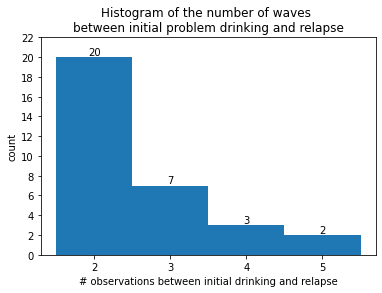

In [22]:
# investigate average time between recovery and relapse
lapses = data[data['lapse']][['id', 'wave']]
problem_to_relapse = []
for lapse in lapses.iterrows():
    original_problem_waves = data[(data['id'] == lapse[1]['id']) & (data['wave'] < lapse[1]['wave']) & (data['drinker_type'] == 'H')]['wave'].tolist()
    if len(original_problem_waves) > 0:
        wave = lapse[1]['wave'] - 1
        observations = 0
        while True:
            if len(data[(data['id'] == lapse[1]['id']) & (data['wave'] == wave)]) > 0:
                observations += 1
            if wave == max(original_problem_waves):
                break
            wave -= 1
        problem_to_relapse.append(observations)

plt.bar_label(plt.hist(problem_to_relapse, bins = [1.5, 2.5, 3.5, 4.5, 5.5])[2])
plt.yticks(range(0, 23, 2))
plt.xticks(range(2, 6))
plt.ylabel('count')
plt.xlabel('# observations between initial drinking and relapse')
plt.title('Histogram of the number of waves \nbetween initial problem drinking and relapse')
plt.savefig('figures/waves_to_relapse_hist.png')
plt.show()

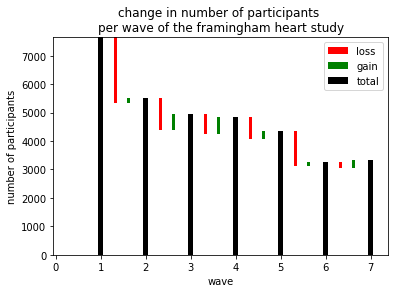

In [23]:
## analize the change in (number of) participants per wave 

# initialize lists
ids_per_wave = []
losses = []
gains = []
totals = []

# get data on number of participants
for wave in range(1, 8):
    ids_per_wave.append(data[data['wave'] == wave]['id'].values)
    cur_wave = ids_per_wave[wave - 1]
    prev_wave = ids_per_wave[wave - 2]
    
    losses.append(-len([id for id in prev_wave if id not in cur_wave]))
    gains.append(len([id for id in cur_wave if id not in prev_wave]))
    totals.append(len(cur_wave))

# format data
waves = list(range(1, 8))
shifted_totals = totals[-1:] + totals[:len(totals) - 1]
totals_and_losses = [total + loss for total, loss in zip(shifted_totals, losses)]

# plot losses
plt.bar([wave - .675 for wave in waves],
        losses,
        bottom = shifted_totals,
        color = 'red',
        width = .075,
        align = 'center',
        label = 'loss')

# plot gains
plt.bar([wave - .375 for wave in waves],
        gains,
        bottom = totals_and_losses,
        color = 'green',
        width = .075,
        align = 'center',
        label = 'gain')

# plot totals
plt.bar(waves,
        totals,
        color = 'black',
        width = .1,
        align = 'center',
        label = 'total')

# plot layout
plt.legend()
plt.title('change in number of participants \nper wave of the framingham heart study')
plt.ylabel('number of participants')
plt.xlabel('wave')
plt.savefig('figures/participants_per_wave.png')
plt.show()

In [24]:
# analysis of relapsers vs. first-time H drinkers
# wrapped in a function because this analysis is done again later

# instead of just counting the first-time lapsers and the relapses, we need to take into account the population
# sizes, since the population of possible relapsers is much smaller than the population of possible first-time 
# lapsers. 

# NOTE: These 2 samples of observations can by definition not have overlap, but participant might belong to 
# different samples during different waves (both lapsing for the first time as well as relapsing over the course 
# of 7 waves) So I am not sure whether these samples are paired or unpaired. I have chosen to use tests that 
# assume unpaired samples, but am not completely convinced of this choice.
def lapse_analysis(wave_min = 1, wave_lim = 8, addition = ''):
    print(len(relapses),
          'relapses out of', 
          len(data[data["recovered"]]), 
          'observations of previously H drinking As')
    print(len(data[data["lapse"] & (data["wave"] >= wave_min)]) - len(relapses),
          'first-time lapsers out of',
          len(data[~data["recovered"] & (data["drinker_type"] == "A") & (data["wave"] >= wave_min)]),
          'observations of non-recovered abstaining')

    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey = True)
    fig.suptitle('histograms of lapses per wave')
    
    sns.countplot(ax = axes[0],
                  data = relapses,
                  x = 'wave', 
                  order = list(range(wave_min, wave_lim)),
                  color = 'blue')
    axes[0].bar_label(axes[0].containers[0])
    axes[0].set_title('relapsers')
    
    sns.countplot(ax = axes[1],
                  data = data[data['lapse'] & ~data['id'].isin(relapses['id'])],
                  x = 'wave', 
                  order = list(range(wave_min, wave_lim)),
                  color = 'blue')
    axes[1].bar_label(axes[1].containers[0])
    axes[1].set_title('first-time lapses')
    
    plt.tight_layout()
    plt.savefig(f'figures/lapses_relapses_per_wave{addition}.png')
    plt.show()

30 relapses out of 1252 observations of previously H drinking As
65 first-time lapsers out of 9458 observations of non-recovered abstaining


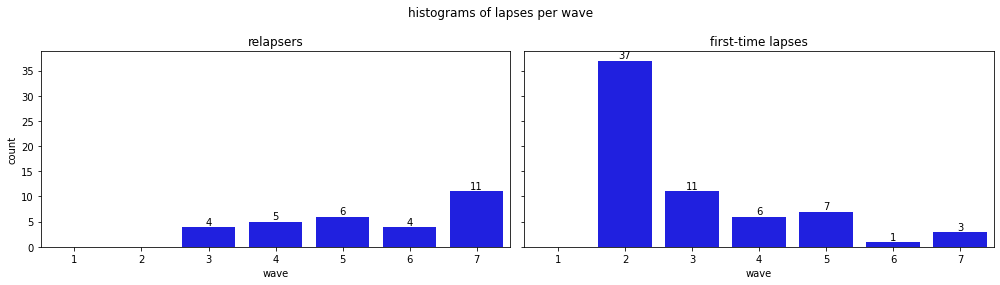

In [25]:
lapse_analysis()

30 relapses out of 1252 observations of previously H drinking As
28 first-time lapsers out of 6373 observations of non-recovered abstaining


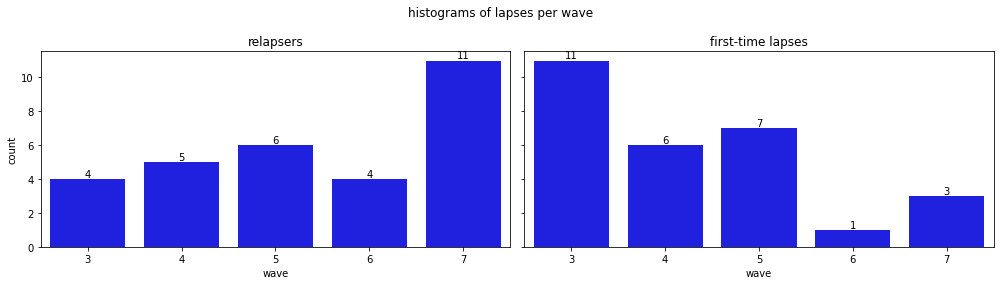

In [26]:
lapse_analysis(wave_min = 3, addition = '_3')

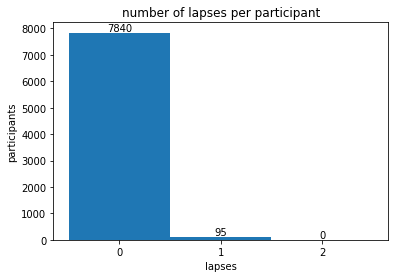

the conclusion from this is that it is not necessary to look at observations, but we can just look at participants.


<Figure size 432x288 with 0 Axes>

In [27]:
## analize number of relapses per person
plt.bar_label(plt.hist(data[['id', 'lapse']].groupby(['id']).sum()['lapse'], 
                       bins = [-.5, .5, 1.5, 2.5])[2])
plt.xticks(ticks = [0, 1, 2])
plt.title('number of lapses per participant')
plt.ylabel('participants')
plt.xlabel('lapses')
plt.show()
plt.savefig('figures/lapses_per_participant.png')
print('the conclusion from this is that it is not necessary to look at observations, but we can just look at participants.')

20 out of 2997 potential first-time lapsers lapsed
32 out of 593 potential relapsers lapsed


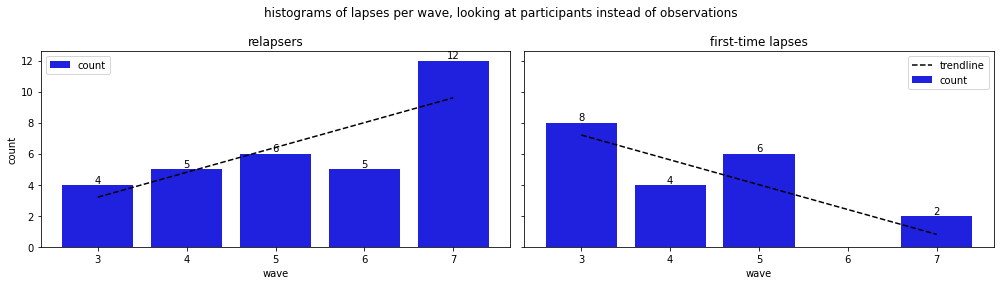

In [28]:
# remove all first-observation abstaining from the pool of possible lapsers 
# to account for the fact that a relapse is a 3-wave process (H-A-H) and indistiguishable 
# from a first-time lapser (A-H) if the wave right before is not present
# NOTE: even after this, it is very possible that first time lapsers are actually relapsers, 
#       but their H drinking was before the first observation.
data_cutoff = data.drop(data.groupby('id')['wave'].idxmin()) 

# define pool of participants that can lapse or relapse at some point during the study
possible_lapsers = list(data_cutoff[(data_cutoff['drinker_type'] == 'A') & ~data_cutoff['recovered']]['id'].unique())
possible_relapsers = list(data[data['recovered']]['id'].unique())
        
# determine number of actual lapsers
lapser_ids = list(data[(data['id'].isin(possible_lapsers)) & data['lapse']]['id'].values)
relapser_wave_ids = list(data[(data['id'].isin(possible_relapsers)) & data['lapse']][['wave', 'id']].values)

# check whether lapse happened before or after recovery
relapser_ids = []
for wave, person_id in relapser_wave_ids:
    if sum(data[(data['id'] == person_id) & (data['wave'] < wave)]['recovered'].values) > 0:
        relapser_ids.append(person_id)
        
# report results
for lapsers, sample, lapse_type in zip([lapser_ids, relapser_ids],
                                       [possible_lapsers, possible_relapsers],
                                       ['first-time ', 're']):
    print(f'{len(lapsers)} out of {len(sample)} potential {lapse_type}lapsers lapsed')
    
# analise waves in which lapses happened to compare to earlier results
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey = True)
fig.suptitle('histograms of lapses per wave, looking at participants instead of observations')

sns.countplot(ax = axes[0],
              data = data[data['id'].isin(relapser_ids) & data['lapse']],
              x = 'wave', 
              order = list(range(3, 8)),
              color = 'blue', 
              label = 'count')
axes[0].bar_label(axes[0].containers[0])
axes[0].set_title('relapsers')

sns.countplot(ax = axes[1],
              data = data[data['id'].isin(lapser_ids) & data['lapse']],
              x = 'wave', 
              order = list(range(3, 8)),
              color = 'blue', 
              label = 'count')
axes[1].bar_label(axes[1].containers[0])
axes[1].set_title('first-time lapses')


# linearly fit the change in number of lapses
waves = list(range(3, 8))
for ids, ax in zip([relapser_ids, lapser_ids], range(2)):
    counts = [len(data[(data['wave'] == wave) & data['id'].isin(ids) & data['lapse']]) for wave in waves]
    
    m, b = np.polyfit(waves, counts, 1)
    axes[ax].plot([m * x + b for x in waves], c = 'black', linestyle = '--', label = 'trendline')

plt.legend()
plt.tight_layout()
# overwrite earlier plot with better analysis
plt.savefig('figures/lapses_relapses_per_wave_3.png')
plt.show()

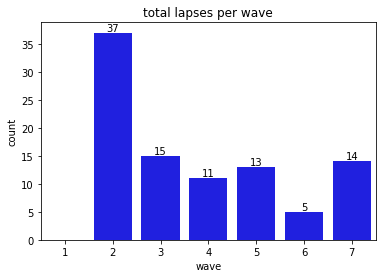

In [29]:
ax = sns.countplot(data = data[data['lapse']],
              x = 'wave', 
              order = list(range(1, 8)),
              color = 'blue')
plt.title('total lapses per wave')
ax.bar_label(ax.containers[0])
plt.savefig('figures/lapses_per_wave.png')
plt.show()

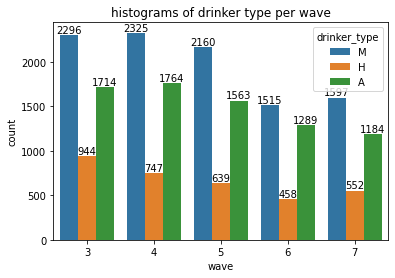

In [30]:
## analise waves in which lapses happened to compare to earlier results
ax = sns.countplot(data = data,
              x = 'wave',
              hue = 'drinker_type',
              order = list(range(3, 8)))
for container in ax.containers:
    ax.bar_label(container)
plt.title('histograms of drinker type per wave')
plt.savefig('figures/type_per_wave.png')
plt.show()

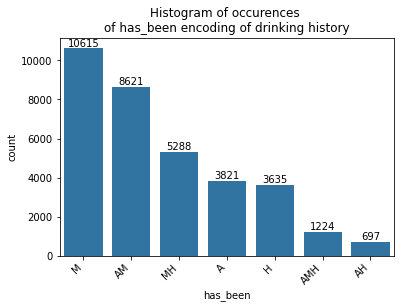

In [31]:
# histogram for how often has_beens cases happen.
ax = sns.countplot(data = data,
              x = 'has_been',
              order = data['has_been'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 45, horizontalalignment = 'right')
plt.title('Histogram of occurences \nof has_been encoding of drinking history')
plt.savefig('figures/sequence_hist.png')
plt.show()

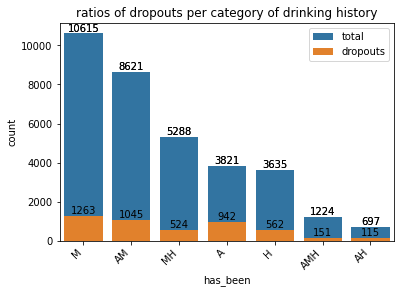

In [32]:
## see if it makes a difference if we take only the last observation per participant, 
## so looking at participants instead of observations

# get last observation per participant
last_wave = data[['id', 'wave']].groupby('id').max('wave').reset_index()
last_wave = last_wave.merge(data,
                on = ['id', 'wave'],
                how = 'left')
dropouts = last_wave[last_wave['wave'] < 7]


# plot total and dropout occurences
for data_set, name in zip([data, dropouts], ['total', 'dropouts']):
    ax = sns.countplot(data = data_set,
                  x = 'has_been',
                  order = data['has_been'].value_counts().index,
                  label = name)
    for container in ax.containers:
        plt.bar_label(container)
    plt.xticks(rotation = 45, horizontalalignment = 'right')

plt.legend()
plt.title('ratios of dropouts per category of drinking history')
plt.savefig('figures/dropouts_per_type.png')
plt.show()

ratio of H drinkers in social networks of lapsers: 0.17727272727272728
ratio of H drinkers in social networks of non-lapsers: 0.1148442272449603


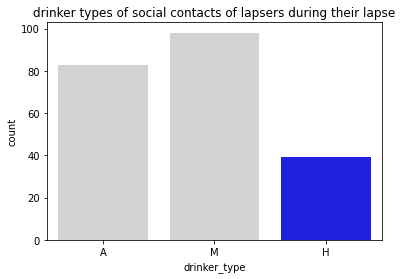

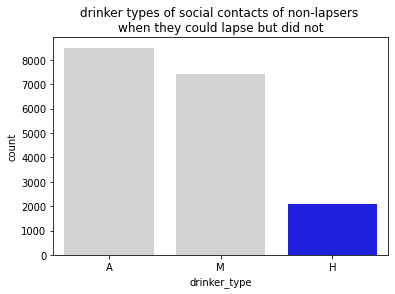

In [33]:
# analize H drinkers in social network of lapsers vs. non-lapsers as a baseline for whether H in social 
# network is a confounding variable for AH in network
possible_lapsers = data[data['drinker_type'] == 'A'][['id', 'wave']]
possible_lapsers['wave'] += 1
possible_lapses = possible_lapsers.merge(data, how = 'inner', on = ['id', 'wave'])

non_lapses_links = possible_lapses[possible_lapses['drinker_type'] != 'H'][['wave', 'links']].explode('links').rename(columns = {'links' : 'id'})
non_lapses_links = non_lapses_links.merge(data, how = 'inner', on = ['id', 'wave'])

lapses_links = possible_lapses[possible_lapses['drinker_type'] == 'H'][['wave', 'links']].explode('links').rename(columns = {'links' : 'id'})
lapses_links = lapses_links.merge(data, how = 'inner', on = ['id', 'wave'])

print('ratio of H drinkers in social networks of lapsers:', len(lapses_links[lapses_links['drinker_type'] == 'H']) / len(lapses_links))
print('ratio of H drinkers in social networks of non-lapsers:', len(non_lapses_links[non_lapses_links['drinker_type'] == 'H']) / len(non_lapses_links))

sns.countplot(data = lapses_links,
              x = 'drinker_type', 
              palette = ['lightgrey', 'lightgrey', 'blue'],
              order = order,
              label = 'count')
plt.title('drinker types of social contacts of lapsers during their lapse')
plt.savefig('figures/contact_type_lapse.png')
plt.show()

sns.countplot(data = non_lapses_links,
              x = 'drinker_type', 
              palette = ['lightgrey', 'lightgrey', 'blue'],
              order = order,
              label = 'count')
plt.title('drinker types of social contacts of non-lapsers \nwhen they could lapse but did not')
plt.savefig('figures/contact_type_non_lapse.png')
plt.show()

ratio of lapsers of H drinkers in social networks of lapsers: 0.1282051282051282


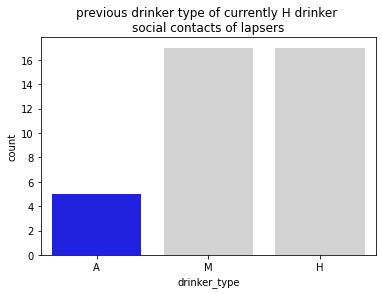

ratio of lapsers of H drinkers in social networks of lapsers: 0.0292157867760123


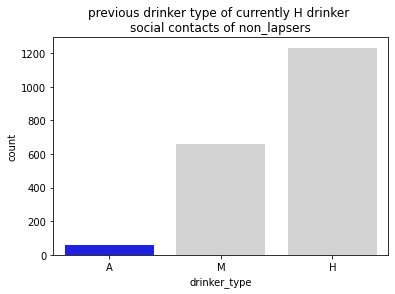

In [34]:
# now we take the H drinkers in both of the groups of social networks and analize their history
def history_of_links(links, non = ''):
    links_history = links[links['drinker_type'] == 'H'][['id', 'wave']]
    links_history['wave'] -= 1 
    links_history = links_history.merge(data, how = 'inner', on = ['id', 'wave'])
    print('ratio of lapsers of H drinkers in social networks of lapsers:', len(links_history[links_history['drinker_type'] == 'A']) / len(links_history))
    
    sns.countplot(data = links_history,
                  x = 'drinker_type', 
                  palette = ['blue', 'lightgrey', 'lightgrey'],
                  order = order,
                  label = 'count')
    plt.title(f'previous drinker type of currently H drinker \nsocial contacts of {non}lapsers')
    plt.savefig(f'figures/contact_type_{non}lapse_min1.png')
    plt.show()

history_of_links(lapses_links)
history_of_links(non_lapses_links, non = 'non_')

In [35]:
# generalized function to perform statistical test and report results
def stat_test(test, h0, data, alpha = .05):
    res = test(data[0], data[1]) if isinstance(data, tuple) else test(data)
    print(f'with a p_value of {res.pvalue:.2e}, we', end = ' ')
    if res.pvalue >= alpha:
        print('do not', end = ' ')
    print(f'have evidence to reject the null hypothesis of this data {h0}')

In [36]:
## test whether earlier H drinking behaviour affects the probability of lapsing
# based on observations
print(chi2_contingency([[len(relapses), 
                         len(data[data['recovered']])], 
                        [len(data[data['lapse'] & (data['wave'] >= 3)]) - len(relapses), 
                         len(data[~data['recovered'] & (data['drinker_type'] == 'A') & (data['wave'] >= 3)])]]))

# based on participants
print(chi2_contingency([[len(relapser_ids), 
                         len(possible_relapsers)], 
                        [len(lapser_ids), 
                         len(possible_lapsers)]]))

Chi2ContingencyResult(statistic=49.10030289594506, pvalue=2.4320265400458165e-12, dof=1, expected_freq=array([[   9.67799037, 1272.32200963],
       [  48.32200963, 6352.67799037]]))
Chi2ContingencyResult(statistic=304.6243806371899, pvalue=3.2381711031953516e-68, dof=1, expected_freq=array([[2.86217525e+00, 6.22137825e+02],
       [4.91378247e+01, 1.06808622e+04]]))


In [37]:
# analysis of contagiousness of lapsing
print('mean number of lapses in links of other lapsers', sum(data[data['lapse']]['lapses_in_links']) / sum(data[data['lapse']]['links'].apply(len)))
print('mean number of lapses in links of non-lapsers', sum(data[~data['lapse']]['lapses_in_links']) / sum(data[~data['lapse']]['links'].apply(len)))

mean number of lapses in links of other lapsers 0.01272264631043257
mean number of lapses in links of non-lapsers 0.0016258765523485986


In [38]:
# test whether distributions of amount of lapses in links are normal
print('for the sample of lapsers:', end = ' ')
stat_test(normaltest, 'being normally distributed', data[data['lapse']]['lapses_in_links'])

print('\nfor the sample of non lapsers:', end = ' ')
stat_test(normaltest, 'being normally distributed', data[~data['lapse']]['lapses_in_links'])

print('\nfor the full dataset:', end = ' ')
stat_test(normaltest, 'being normally distributed', data['lapses_in_links'])

for the sample of lapsers: with a p_value of 6.89e-24, we have evidence to reject the null hypothesis of this data being normally distributed

for the sample of non lapsers: with a p_value of 0.00e+00, we have evidence to reject the null hypothesis of this data being normally distributed

for the full dataset: with a p_value of 0.00e+00, we have evidence to reject the null hypothesis of this data being normally distributed


In [39]:
# test whether distributions of amount of lapses in links have equal variance
stat_test(levene, 'having equal variance', (data[data['lapse']]['lapses_in_links'], data[~data['lapse']]['lapses_in_links']))

with a p_value of 1.75e-06, we have evidence to reject the null hypothesis of this data having equal variance


In [40]:
# test whether lapses are more likely to occur to people with more links that are also lapsing
mannwhitneyu(data[data['lapse']]['lapses_in_links'], 
             data[~data['lapse']]['lapses_in_links'], 
             alternative = 'greater')

MannwhitneyuResult(statistic=1679515.0, pvalue=2.7815481353469988e-08)

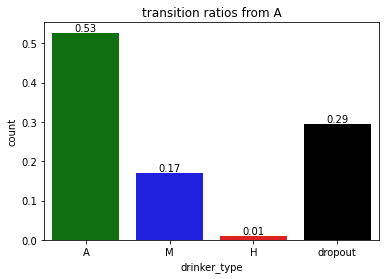

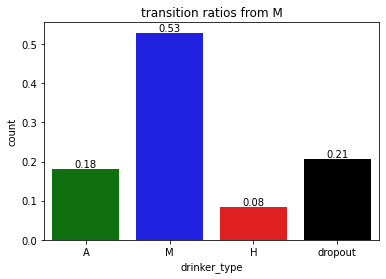

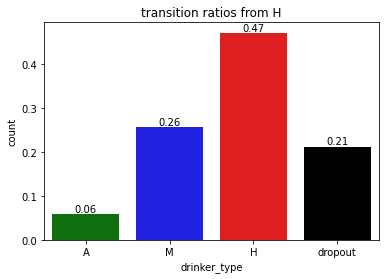

,ratio,from,to
0,0.746856,A,A
1,0.240567,A,M
2,0.012578,A,H
0,0.665975,M,M
1,0.228220,M,A
2,0.105806,M,H
0,0.599101,H,H
1,0.326931,H,M
2,0.073968,H,A


In [41]:
# create state transition diagram based on bata of drinker type
# out of the state transitions, look at has_beens (first individually, then combinations)
transition_ratios = pd.DataFrame()
for drinker_type in drinker_types:
    # get participants with current drinker type
    participants = data[data['drinker_type'] == drinker_type][['id', 'wave']]
    participant_count = len(participants)
    
    ## get next wave of those participants
    # make empty df for next available wave
    participants_next = pd.DataFrame()
    for wave in waves:
        # increase wave to find in data
        participants['wave'] += 1
        # add data of next wave while retaining index
        participants_next = pd.concat([participants_next, data.merge(participants.reset_index(), how = 'inner', on = ['id', 'wave'])]).set_index('index')
        # use index of found data to delete datapoints and prevent further lookahead
        participants = participants.drop(participants_next.index[~pd.isnull(participants_next.index)])
    
    # determine ratios
    transition_counts = participants_next['drinker_type'].value_counts()
    transition_counts['dropout'] = len(participants)
    
    # save ratios for later
    ratios = pd.DataFrame()
    ratios['ratio'] = transition_counts[:-1] / len(participants_next)
    ratios['from'] = drinker_type
    ratios['to'] = transition_counts.index[:-1]
    ratios = ratios.reset_index(drop = True)
    transition_ratios = pd.concat([transition_ratios, ratios])
    
    # plot results
    ax = sns.barplot(data = transition_counts / participant_count,
                     order = drinker_types + ['dropout'], 
                     palette = ['green', 'blue', 'red', 'black'])
    for container in ax.containers:
        ax.bar_label(container, fmt = '%.2f')     
    plt.title(f'transition ratios from {drinker_type}')
    plt.savefig(f'figures/transition_from_{drinker_type}.png')
    plt.show()
    
transition_ratios

In [42]:
## add column for the number of links of a participant during an observation
data['links_count'] = data['links'].apply(len).fillna(0)
data

,id,wave,cH,cM,cA,drinks_per_week,drinker_type,age,drinker_type_prev,has_been,lapse,recovered,links,lapses_in_links,drinker_type_next,links_count
0,18916,1,1,1,0,1,M,30.0,NaN,M,False,False,"[19234, 9338, 3687, 22976]",0,NaN,4
1,3687,1,2,8,1,26,H,28.0,NaN,H,False,False,"[19234, 9338, 22976, 9390, 22654, 15008, 25568...",0,NaN,13
2,11189,1,1,6,1,21,H,22.0,NaN,H,False,False,"[3687, 9390, 15008, 25568, 1780, 17046, 18969,...",0,NaN,8
3,17046,1,2,5,1,14,M,23.0,NaN,M,False,False,"[3687, 9390, 15008, 25568, 1780, 11189, 18969,...",0,NaN,8
4,18969,1,2,5,1,7,M,24.0,NaN,M,False,False,"[3687, 9390, 15008, 25568, 1780, 11189, 17046,...",0,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33896,23382,6,0,0,0,0,A,57.0,M,AM,False,False,[],0,NaN,0
33897,3047,6,0,0,0,0,A,82.0,A,AM,False,False,[],0,A,0
33898,6844,7,0,0,0,0,A,68.0,M,AM,False,False,[],0,NaN,0
33899,23530,7,0,0,0,6,M,50.0,M,M,False,False,[],0,M,0


In [43]:
## encode history in transition diagram by looking at current and previous drinker type
transition_diagram = data[['id', 'wave', 'drinker_type_prev', 'drinker_type']]
transition_diagram['from'] = transition_diagram['drinker_type_prev'] + transition_diagram['drinker_type']
transition_diagram['wave'] += 1
transition_diagram = transition_diagram.drop(columns = ['drinker_type', 'drinker_type_prev'])
transition_diagram = transition_diagram.merge(data, on = ['id', 'wave'], how = 'left')[['from', 'drinker_type']].rename(columns = {'drinker_type' : 'to'}).dropna()
transition_diagram['count'] = 0
transition_diagram = transition_diagram.groupby(['from', 'to']).count()

transition_diagram = transition_diagram.reset_index()
transition_diagram

,from,to,count
0,AA,A,3061
1,AA,H,7
2,AA,M,569
3,AH,A,9
4,AH,H,22
5,AH,M,26
6,AM,A,539
7,AM,H,34
8,AM,M,714
9,HA,A,177


In [44]:
## add ratios to transition diagram

# drop links if already made to prevent breaking the code
transition_diagram = drop_columns(transition_diagram, ['population', 'ratio'])

populations = transition_diagram.groupby('from').sum('count').reset_index()
populations = populations.rename(columns = {'count' : 'population'})
transition_diagram = populations.merge(transition_diagram,
                                       on = 'from',
                                       how = 'outer')
transition_diagram['ratio'] = transition_diagram['count'] / transition_diagram['population']
transition_diagram = drop_columns(transition_diagram, ['population'])
transition_diagram

,from,to,count,ratio
0,AA,A,3061,0.841628
1,AA,H,7,0.001925
2,AA,M,569,0.156448
3,AH,A,9,0.157895
4,AH,H,22,0.385965
5,AH,M,26,0.456140
6,AM,A,539,0.418803
7,AM,H,34,0.026418
8,AM,M,714,0.554779
9,HA,A,177,0.683398


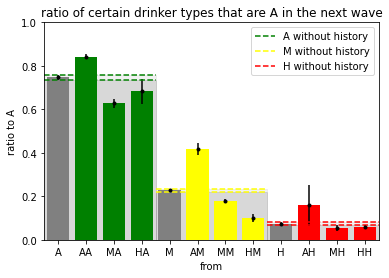

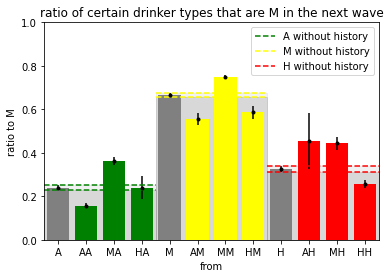

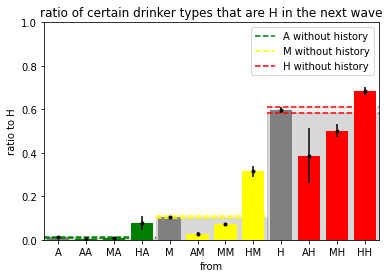

In [45]:
## plot the composition of drinking types
def from_to(to = 'H'):
    bars = []
    heights = []
    category_counts = transition_diagram[['from', 'count']].groupby('from').sum('count').reset_index()
    counts = []
    
    # ratio of [from_1] -> [to]
    for from_1 in drinker_types:
        a_to_x = len(data[(data['drinker_type_prev'] == from_1) & (data['drinker_type'] == to)])
        a = len(data[data['drinker_type_prev'] == from_1])
        bars.append(from_1)
        heights.append(a_to_x / a)
        counts.append(a)
        
        # ratio of [from_2][from_1] -> [to]
        for from_2 in drinker_types:
            froms = from_2 + from_1
            ba_to_x = transition_diagram[(transition_diagram['from'] == froms) & (transition_diagram['to'] == to)]['count'].sum()
            ba = transition_diagram[transition_diagram['from'] == froms]['count'].sum()
            bars.append(froms)
            heights.append(ba_to_x / ba)
            counts.append(ba)

    bar_colors = np.array([['grey'] + [colors[drinker_type]] * 3 for drinker_type in drinker_types]).flatten()
    
    plt.bar(bars, heights,
            color = ['grey'] + ['green'] * 3 + ['grey'] + ['yellow'] * 3 + ['grey'] + ['red'] * 3)
    
    cs = [1.96 * sqrt((ratio * (1 - ratio)) / count) for ratio, count in zip(heights, counts)]
    plt.errorbar(bars, heights, yerr = cs, fmt = '.', color = 'black')
    
    fill_x = [-1, 3.5, 7.5, 12]
    for idx, drinker_type in zip(range(0, len(heights), 4), drinker_types):
        plt.axhline(heights[idx] + cs[idx], 
                    color = colors[drinker_type], 
                    linestyle = '--', 
                    label = f'{drinker_type} without history', 
                    xmin = idx / 12, 
                    xmax = idx / 12 + (1 / 3))
        plt.axhline(heights[idx] - cs[idx], 
                    color = colors[drinker_type], 
                    linestyle = '--', 
                    xmin = idx / 12, 
                    xmax = idx / 12 + (1 / 3))
        plt.fill_between(fill_x[idx//4:idx//4 + 2], 0, heights[idx] - cs[idx], alpha = .3, color = 'grey')
        plt.fill_between(fill_x[idx//4:idx//4 + 2], heights[idx] - cs[idx], heights[idx] + cs[idx], alpha = .3, color = 'lightgrey')
        
        
    plt.ylabel(f'ratio to {to}')
    plt.title(f'ratio of certain drinker types that are {to} in the next wave')
    plt.xlabel('from')
    plt.xlim(-.5, 11.5)
    plt.ylim(0, 1)
    plt.legend()
    plt.savefig(f'figures/transition_to_{to}.png')
    plt.show()
    
for drinker_type in drinker_types:
    from_to(drinker_type)

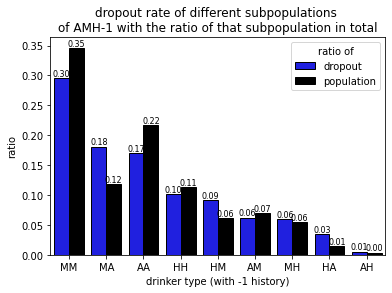

In [46]:
# dropout rates
dropouts = data[data['drinker_type_next'].isnull() & (data['wave'] < 7)][['drinker_type_prev', 'drinker_type']].dropna()
dropout_types = (dropouts['drinker_type_prev'] + dropouts['drinker_type']).value_counts()
dropout_types = dropout_types.apply(lambda x : x / dropout_types.sum()).reset_index()
dropout_types['ratio of'] = 'dropout'

# population rates
pops = data[['drinker_type_prev', 'drinker_type']].dropna()
pops_types = (pops['drinker_type_prev'] + pops['drinker_type']).value_counts()
pops_types = pops_types.apply(lambda x : x / pops_types.sum()).reset_index()
pops_types['ratio of'] = 'population'

# combine into 1 dataframe
dropout_types = pd.concat([dropout_types, pops_types]).rename(columns = {'index' : 'drinker_type', 'count' : 'ratio'})

# plot
containers = sns.barplot(data = dropout_types,
            x = 'drinker_type',
            y = 'ratio',
            hue = 'ratio of',
            palette = ['blue', 'black'],
            edgecolor = 'black').containers
for container in containers:
    plt.bar_label(container, fmt = '%.2f', fontsize = 8)
plt.title('dropout rate of different subpopulations \nof AMH-1 with the ratio of that subpopulation in total')
plt.xlabel('drinker type (with -1 history)')
plt.savefig('figures/dropouts.png')
plt.show()

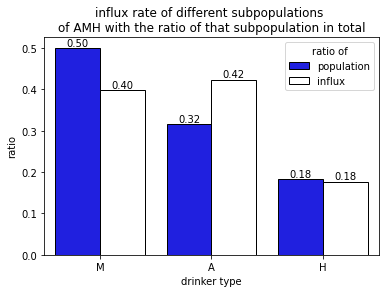

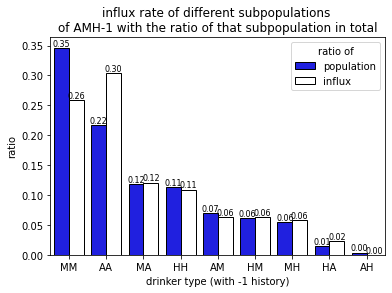

In [47]:
# investigate new participants
# remove those who were here from wave 1
not_new_ids = data[data['wave'] == 1]['id']
new_ids = list(set(data['id'].unique()) - set(not_new_ids))
new_dict = {'A' : 0, 'M' : 0, 'H' : 0}
total = 0
for new_id in new_ids:
    agent_data = data[data['id'] == new_id][['wave', 'drinker_type']]
    new_dict[agent_data[agent_data['wave'] == agent_data['wave'].min()]['drinker_type'].iloc[0]] += 1
    total += 1

new_dict = {key : value / total for key, value in new_dict.items()}

pops = data['drinker_type'].value_counts().reset_index()
pops['count'] /= sum(pops['count'])
pops['ratio of'] = 'population'
births = pd.DataFrame(new_dict.items(), columns = ['drinker_type', 'count'])
births['ratio of'] = 'influx'
births = pd.concat([pops, births])

# now with history
new_dict_history = {drinker_type_prev + drinker_type : 0 for drinker_type in drinker_types for drinker_type_prev in drinker_types}
total_history = 0
for new_id in new_ids:
    agent_data = data[data['id'] == new_id][['wave', 'drinker_type']]
    drinker_type_prev = agent_data[agent_data['wave'] == agent_data['wave'].min()]['drinker_type'].iloc[0]
    agent_data = agent_data[agent_data['wave'] > agent_data['wave'].min()]
    drinker_type = agent_data[agent_data['wave'] == agent_data['wave'].min()]['drinker_type']
    if len(drinker_type) > 0:
        drinker_type = drinker_type.iloc[0]
        new_dict_history[drinker_type_prev + drinker_type] += 1
        total_history += 1

new_dict_history = {key : value / total_history for key, value in new_dict_history.items()}

pops_history = (data['drinker_type_prev'] + data['drinker_type']).value_counts().reset_index().rename(columns = {'index' : 'drinker_type'})
pops_history['count'] /= sum(pops_history['count'])
pops_history['ratio of'] = 'population'
births_history = pd.DataFrame(new_dict_history.items(), columns = ['drinker_type', 'count'])
births_history['ratio of'] = 'influx'
births_history = pd.concat([pops_history, births_history])

containers = sns.barplot(data = births,
            x = 'drinker_type',
            y = 'count',
            hue = 'ratio of',
            palette = ['blue', 'white'],
            edgecolor = 'black').containers
for container in containers:
    plt.bar_label(container, fmt = '%.2f')
plt.title('influx rate of different subpopulations \nof AMH with the ratio of that subpopulation in total')
plt.ylabel('ratio')
plt.xlabel('drinker type')
plt.savefig('figures/births.png')
plt.show()

containers = sns.barplot(data = births_history,
            x = 'drinker_type',
            y = 'count',
            hue = 'ratio of',
            palette = ['blue', 'white'],
            edgecolor = 'black').containers
for container in containers:
    plt.bar_label(container, fmt = '%.2f', fontsize = 8)
plt.title('influx rate of different subpopulations \nof AMH-1 with the ratio of that subpopulation in total')
plt.ylabel('ratio')
plt.xlabel('drinker type (with -1 history)')
plt.savefig('figures/births_history.png')
plt.show()

In [48]:
## add drinker state with history of 1 to data

# get link data
links = data[['id', 'wave', 'links']].explode('links').rename(columns = {'id': 'source_id',
                                                                         'links' : 'id'})
links = links.merge(data[['id', 'wave', 'drinker_type', 'drinker_type_prev']],
                    on = ['id', 'wave'],
                    how = 'left')
links = links.dropna()

# format link type with 1 history
for col in ['drinker_type', 'drinker_type_prev']:
    links[col] = links[col].apply(lambda s : s[0].upper())  
links['link_type_2'] = links['drinker_type_prev'] + links['drinker_type']
links = drop_columns(links, ['drinker_type', 'drinker_type_prev'])

links = links.groupby(['wave', 'source_id', 'link_type_2']).count().reset_index().rename(columns = {'id' : 'count', 'source_id' : 'id'})

for link_types in links['link_type_2'].unique():
    data = drop_columns(data, [f'c{link_types}'])
    data = links[links['link_type_2'] == link_types][['id', 'wave', 'count']].merge(data, on = ['id', 'wave'], how = 'right')
    data['count'] = data['count'].fillna(0).astype(int)
    data = data.rename(columns = {'count' : f'c{link_types}'})
    
data

,id,wave,cAH,cHM,cHA,cMH,cAM,cMM,cHH,cAA,...,drinker_type,age,drinker_type_prev,has_been,lapse,recovered,links,lapses_in_links,drinker_type_next,links_count
0,18916,1,0,0,0,0,0,0,0,0,...,M,30.0,NaN,M,False,False,"[19234, 9338, 3687, 22976]",0,NaN,4
1,3687,1,0,0,0,0,0,0,0,0,...,H,28.0,NaN,H,False,False,"[19234, 9338, 22976, 9390, 22654, 15008, 25568...",0,NaN,13
2,11189,1,0,0,0,0,0,0,0,0,...,H,22.0,NaN,H,False,False,"[3687, 9390, 15008, 25568, 1780, 17046, 18969,...",0,NaN,8
3,17046,1,0,0,0,0,0,0,0,0,...,M,23.0,NaN,M,False,False,"[3687, 9390, 15008, 25568, 1780, 11189, 18969,...",0,NaN,8
4,18969,1,0,0,0,0,0,0,0,0,...,M,24.0,NaN,M,False,False,"[3687, 9390, 15008, 25568, 1780, 11189, 17046,...",0,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33896,23382,6,0,0,0,0,0,0,0,0,...,A,57.0,M,AM,False,False,[],0,NaN,0
33897,3047,6,0,0,0,0,0,0,0,0,...,A,82.0,A,AM,False,False,[],0,A,0
33898,6844,7,0,0,0,0,0,0,0,0,...,A,68.0,M,AM,False,False,[],0,NaN,0
33899,23530,7,0,0,0,0,0,0,0,0,...,M,50.0,M,M,False,False,[],0,M,0


In [49]:
## create transition diagram depending on number of contacts of a drinker type
social_network_diagram = pd.DataFrame()
for drinker_type in drinker_types:
    # make capped version of links
    data[f'c{drinker_type}_capped'] = data[f'c{drinker_type}'].apply(lambda x : x if x <= 5 else 5)
    
    # count occurences
    new = data.groupby(['drinker_type', 'drinker_type_next', f'c{drinker_type}_capped'])[['id']].count()
    new = new.reset_index().rename(columns = {'id' : 'count'})
    new = new.rename(columns = {f'c{drinker_type}_capped' : 'n_links'})
    new['link_type'] = drinker_type
    
    # add this to the full diagram
    social_network_diagram = pd.concat([social_network_diagram, new])


for link_type in drinker_types:
    for link_type_prev in drinker_types:
        link_types = link_type_prev + link_type
        
        # make capped version of links
        data[f'c{link_types}_capped'] = data[f'c{link_types}'].apply(lambda x : x if x <= 5 else 5)

        # count occurences
        new = data.groupby(['drinker_type', 'drinker_type_next', f'c{link_types}_capped'])[['id']].count()
        new = new.reset_index().rename(columns = {'id' : 'count'})
        new = new.rename(columns = {f'c{link_types}_capped' : 'n_links'})
        new['link_type'] = link_types

        # add this to the full diagram
        social_network_diagram = pd.concat([social_network_diagram, new])

# replace cXY with capped version
for category in drinker_types + [drinker_type_prev + drinker_type for drinker_type_prev in drinker_types for drinker_type in drinker_types]:
    data[f'c{category}'] = data[f'c{category}_capped']
    data = drop_columns(data, [f'c{category}_capped'])
        
# formatting
social_network_diagram = social_network_diagram.reset_index(drop = True)
social_network_diagram

,drinker_type,drinker_type_next,n_links,count,link_type
0,A,A,0,1724,A
1,A,A,1,1891,A
2,A,A,2,950,A
3,A,A,3,450,A
4,A,A,4,168,A
...,...,...,...,...,...
520,M,M,1,1487,HH
521,M,M,2,313,HH
522,M,M,3,52,HH
523,M,M,4,10,HH


In [50]:
from_type = 'A'
decrease_strength = .1

for link_type in ['AM', 'HM']:
    link_count = 1

    social_transitions = social_network_diagram[(social_network_diagram['drinker_type'] == from_type) 
                                              #& (social_network_diagram['drinker_type_next'] == to_type) 
                                              & (social_network_diagram['link_type'] == link_type)
                                              & (social_network_diagram['n_links'] == link_count)]

    display(social_transitions)
    n_samples = sum(social_transitions['count'])
    for drinker_type in drinker_types:
        print(drinker_type, social_transitions[social_transitions['drinker_type_next'] == drinker_type]['count'].iloc[0] / n_samples)
    
    display(transition_ratios[transition_ratios['from'] == from_type])
    
#     n_total = sum(social_network_diagram[social_network_diagram['link_type'] == 'A']['count'])
#     print('number of samples:', n_samples, 'of', n_total)
#     print('decrease:', 1 / (n_samples / n_total))
#     print('decrease_strength incorporated weight:', decrease_strength * (1 / (n_samples / n_total)))


,drinker_type,drinker_type_next,n_links,count,link_type
287,A,A,1,769,AM
292,A,H,1,32,AM
296,A,M,1,337,AM


A 0.6757469244288224
M 0.2961335676625659
H 0.028119507908611598


,ratio,from,to
0,0.746856,A,A
1,0.240567,A,M
2,0.012578,A,H


,drinker_type,drinker_type_next,n_links,count,link_type
377,A,A,1,491,HM
382,A,H,1,56,HM
386,A,M,1,302,HM


A 0.5783274440518257
M 0.35571260306242636
H 0.06595995288574794


,ratio,from,to
0,0.746856,A,A
1,0.240567,A,M
2,0.012578,A,H


In [51]:
social_network_diagram['count_at_least'] = social_network_diagram.apply(lambda row : sum(social_network_diagram[(social_network_diagram['n_links'] >= row['n_links'])
                                & (social_network_diagram['drinker_type'] == row['drinker_type'])
                                & (social_network_diagram['drinker_type_next'] == row['drinker_type_next'])
                                & (social_network_diagram['link_type'] == row['link_type'])]['count']), axis = 1)
display(social_network_diagram)

,drinker_type,drinker_type_next,n_links,count,link_type,count_at_least
0,A,A,0,1724,A,5336
1,A,A,1,1891,A,3612
2,A,A,2,950,A,1721
3,A,A,3,450,A,771
4,A,A,4,168,A,321
...,...,...,...,...,...,...
520,M,M,1,1487,HH,1864
521,M,M,2,313,HH,377
522,M,M,3,52,HH,64
523,M,M,4,10,HH,12


In [52]:
drinker_typess = [drinker_type_prev + drinker_type for drinker_type in drinker_types for drinker_type_prev in [''] + drinker_types]
s = pd.DataFrame([[drinker_typess, drinker_types, drinker_types]], columns = ['link', 'from', 'to']).explode('link').explode('from').explode('to')
s['s'] = 0.0

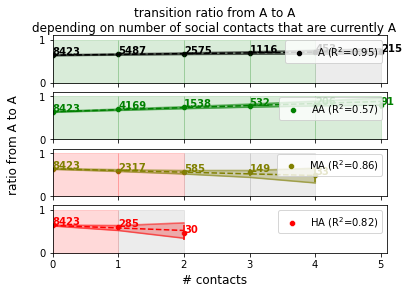

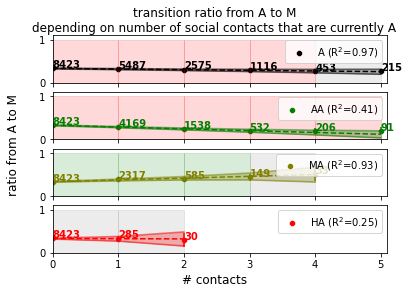

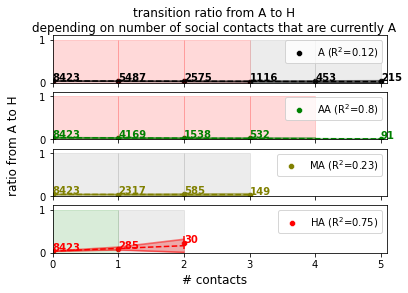

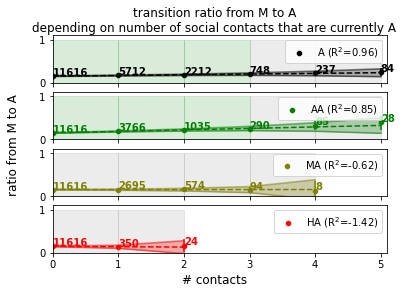

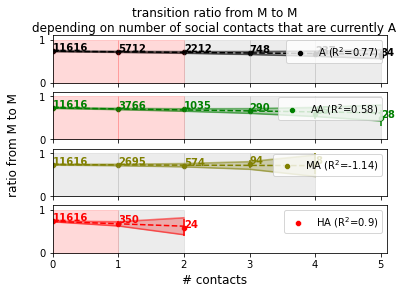

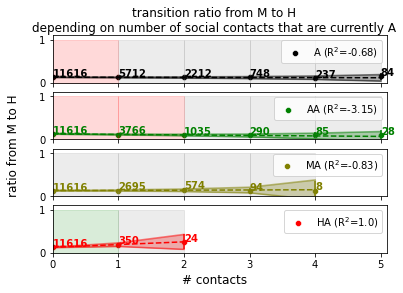

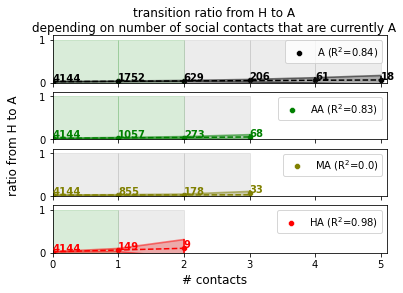

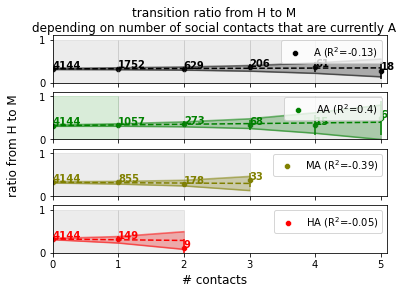

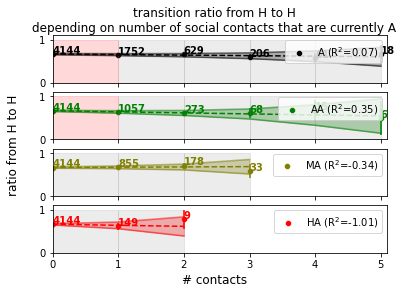

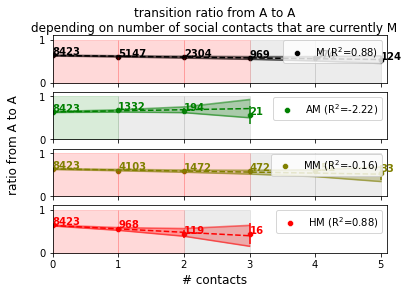

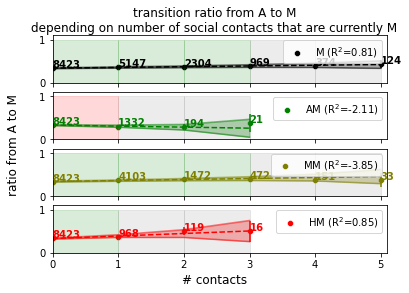

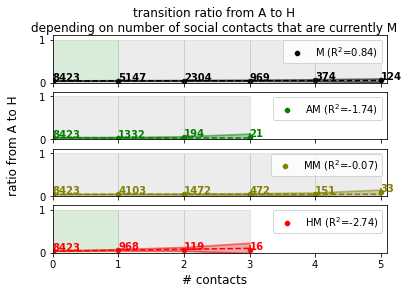

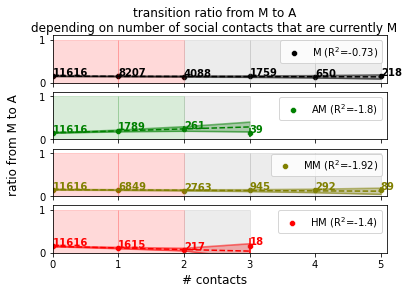

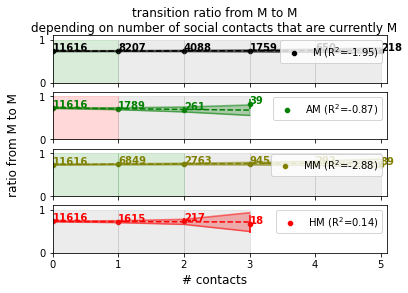

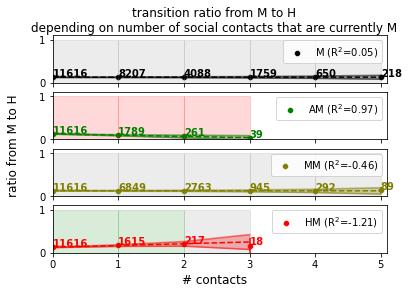

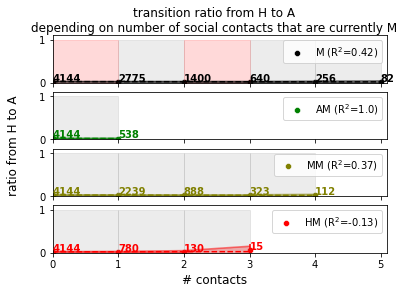

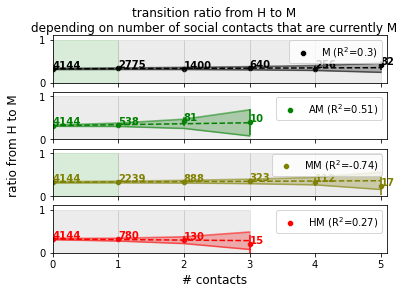

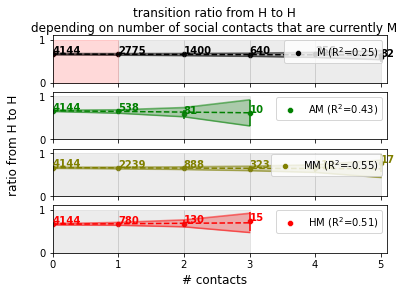

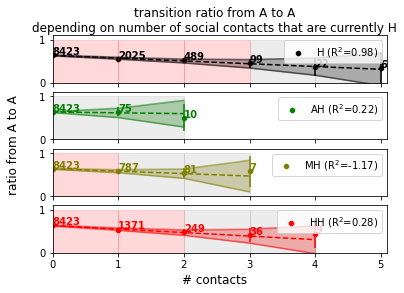

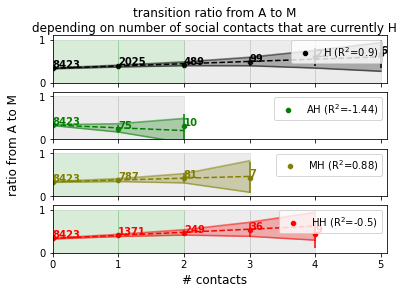

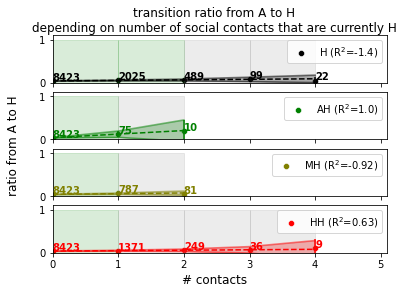

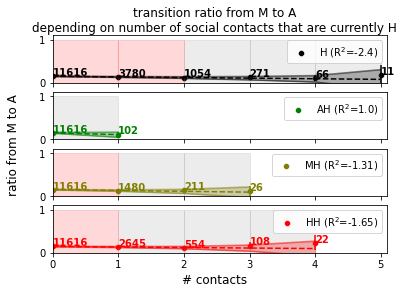

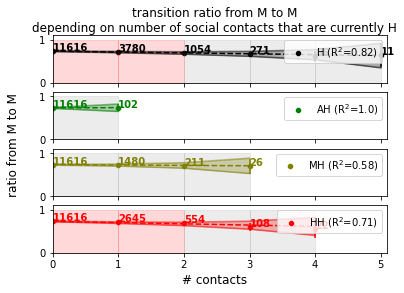

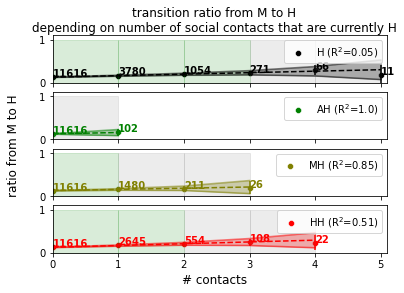

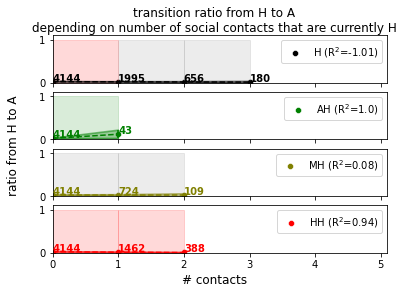

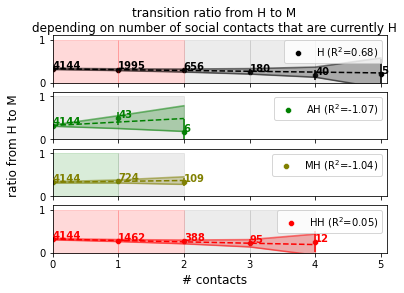

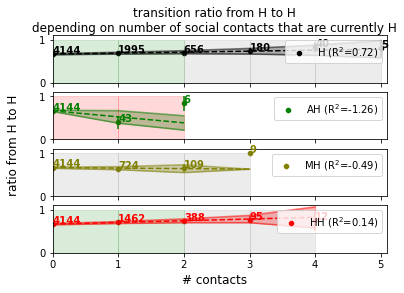

,link,from,to,s
0,A,A,A,0.018059
0,A,A,M,-0.015138
0,A,A,H,0.000000
0,A,M,A,0.016116
0,A,M,M,-0.013707
...,...,...,...,...
0,HH,M,M,-0.029111
0,HH,M,H,0.041582
0,HH,H,A,-0.008761
0,HH,H,M,0.000000


In [57]:
## plot the relation of number of contacts of a drinker type on a transition
def plot_links_effect(ax, transitions, color, all_handles, all_labels, drinker_type, drinker_type_next, link_type):
    # weighted linear regression
    regr = LinearRegression()
    x_reshaped = transitions['n_links'].to_numpy().reshape(-1, 1)
    regr.fit(x_reshaped, transitions['ratio'], sample_weight = transitions['total'])
    predicted = regr.predict(x_reshaped)
    ax.plot(x_reshaped, predicted, color = color, linestyle = '--')
    
    # plot real data
    r_score = regr.score(x_reshaped, transitions["ratio"])
    sns.scatterplot(data = transitions,
                    x = 'n_links',
                    y = 'ratio', 
                    color = color,
                    label = link_type + f' (R$^2$={round(r_score, 2)})',
                    ax = ax)
    
    # plot number of samples
    for _, row in transitions.iterrows():
        ax.annotate(int(row['total']), (row['n_links'], row['ratio'] + .02), weight = 'bold', color = color)
  
    # for the data and determine uncertainty
    confidence_intervals = proportion.proportion_confint(transitions['count_at_least'], transitions['total'])
    y_err = np.array(confidence_intervals[1] - transitions['ratio'])
    
    # plot uncertainty of real data points
    ax.errorbar(np.array(transitions['n_links']),  
                 np.array(transitions['ratio']), 
                 yerr = y_err, ls = '',
                 color = color)

    # plot uncertainty of linear fit
    ax.plot([y + err for err, y in zip(y_err, predicted)], c = color, alpha = .5)
    ax.plot([y - err for err, y in zip(y_err, predicted)], c = color, alpha = .5)
    ax.fill_between(transitions['n_links'],
                    [y + err for err, y in zip(y_err, predicted)],
                    [y - err for err, y in zip(y_err, predicted)],
                    color = color,
                    alpha = .3)
    
    # check where slope of worst-case within condifence interval is not horizontal
    where = []
    lower_prev = None
    for err, y in zip(y_err, predicted):
        lower = y - err
        upper = y + err

        if lower_prev is not None:
            where.append((lower > lower_prev,  upper > upper_prev))

        lower_prev = lower
        upper_prev = upper

    # color plot based on whether definite slope is found
    effect_found = False
    for n_links in range(len(where)):
        if where[n_links][0] and where[n_links][1]:
            color = 'green'
            effect_found = True
        elif (not where[n_links][0]) and (not where[n_links][1]):
            color = 'red'
            effect_found = True
        else: # no consistant slope
            color = 'grey'
            
        ax.fill_between([n_links, n_links + 1], 
                         0, 
                         1, 
                         color = color,
                         alpha = .15)
        
    # move labels and layers to figure level
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend(loc = 'upper right')
    
    # save social spreading parameter
    if effect_found and r_score > .4:
        s.loc[(s['link'] == link_type) 
            & (s['from'] == drinker_type) 
            & (s['to'] == drinker_type_next), 's'] = regr.coef_[0]
        
        
for link_type in drinker_types:
    for drinker_type in drinker_types:
        
        cur = social_network_diagram[ (social_network_diagram['drinker_type'] == drinker_type)
                                    & (social_network_diagram['link_type'] == link_type)][['drinker_type_next', 'n_links', 'count_at_least']]
        totals = cur[['n_links', 'count_at_least']].groupby(['n_links']).sum().reset_index()

        for drinker_type_next in drinker_types:
            fig, axs = plt.subplots(4, 1, sharex = True, sharey = True)
            all_handles = []
            all_labels = []
            
            cur_to = cur[cur['drinker_type_next'] == drinker_type_next][['n_links', 'count_at_least']]
            cur_to = cur_to.merge(totals.rename(columns = {'count_at_least' : 'total'}), 
                                  on = ['n_links'], 
                                  how = 'left')
            cur_to['ratio'] = cur_to['count_at_least'] / cur_to['total']
            
            plot_links_effect(axs[0], cur_to, 'black', all_handles, all_labels, drinker_type, drinker_type_next, link_type)
            
            for link_type_prev, color, ax in zip(drinker_types, ['green', 'olive', 'red'], axs[1:]):
                link_types = link_type_prev + link_type[0].upper()
                
                cur_history = social_network_diagram[ (social_network_diagram['drinker_type'] == drinker_type)
                                                    & (social_network_diagram['link_type'] == link_types)
                                                    ][['drinker_type_next', 'n_links', 'count_at_least']]
                cur_totals = cur_history[['n_links', 'count_at_least']].groupby(['n_links']).sum().reset_index()
                cur_history = cur_history[cur_history['drinker_type_next'] == drinker_type_next][['n_links', 'count_at_least']]
                cur_history = cur_history.merge(cur_totals.rename(columns = {'count_at_least' : 'total'}), 
                                           on = ['n_links'], 
                                           how = 'left')
                cur_history['ratio'] = cur_history['count_at_least'] / cur_history['total']
                
                cur_history = cur_history.drop(cur_history[cur_history['total'] < 6].index)
                
                plot_links_effect(ax, cur_history, color, all_handles, all_labels, drinker_type, drinker_type_next, link_types)
                
            fig.supylabel(f'ratio from {drinker_type} to {drinker_type_next}')
            fig.supxlabel('# contacts')
            fig.suptitle(f'transition ratio from {drinker_type} to {drinker_type_next}\ndepending on number of social contacts that are currently {link_type}')
            
            plt.xlim(0, 5.1)
            plt.ylim(0, 1.1)
            plt.savefig(f'figures/contacts_{link_type}_{drinker_type}{drinker_type_next}.png')
            plt.show()

display(s)

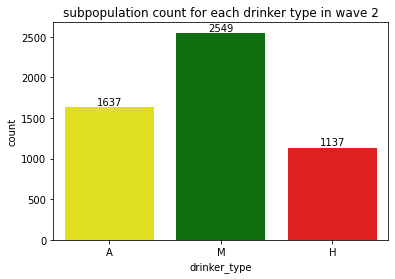

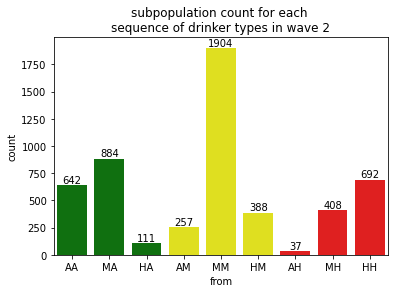

In [54]:
wave_2 = data[data['wave'] == 2].dropna(subset = ['drinker_type_prev'])[['drinker_type_prev', 'drinker_type']]
wave_2['from'] = wave_2['drinker_type_prev'] + wave_2['drinker_type']
containers = sns.countplot(data = wave_2,
                   x = 'drinker_type',
                   palette = ['yellow', 'green', 'red'],
                   order = order).containers
for container in containers:
    plt.bar_label(container)
plt.title('subpopulation count for each drinker type in wave 2')
plt.savefig('figures/wave_2.png')
plt.show()

containers = sns.countplot(data = wave_2,
                   x = 'from',
                   order = [cat_prev + cat for cat in drinker_types for cat_prev in drinker_types],
                   palette = ['green'] * 3 + ['yellow'] * 3 + ['red'] * 3).containers
for container in containers:
    plt.bar_label(container)
plt.title('subpopulation count for each \nsequence of drinker types in wave 2')
plt.savefig('figures/wave_2_history.png')
plt.show()

In [56]:
# make folder if it does not exist yet
if not os.path.exists('data'):
    os.mkdir('data')

# save data to files
data[['id', 'wave', 'drinker_type_prev', 'drinker_type', 'links'] + [f'c{cat_prev + cat}' for cat in drinker_types for cat_prev in [''] + drinker_types]].to_csv('data/data.csv', index = False)

transition_ratios.to_csv('data/transitions_AMHa.csv', index = False)
transition_diagram[['from', 'to', 'ratio']].to_csv('data/transitions_AMHa2.csv', index = False)

s[s['link'].str.len() == 1].to_csv('data/s_AMHa.csv', index = False)
s[s['link'].str.len() == 2].to_csv('data/s_AMHa2.csv', index = False)